###ADS Final Project Submission ###
####Group 24####

*   Shika Shyam
*   Deepika Balasubramaniam

###Hate Speech Detection and Classification on Tweets###

In this project our goal is to classify tweets as hate speech or related and non-hate speech. In a more specific sense, we will be classifying tweets into one of four categories - Normal, Spam, Abusive and Hateful. 

Below is the objective of this project detailed:


*   We will be cleaning the tweets by removing special characters and non alphanumeric characters, and then using NLP Text preprocessing techniques.
* For text preprocessing we will be using Stemming or Lemmatization, and see how these perform against each other.
* We will be making use of 4 different techniques to do feature engineering - i.e. converting the tweets into feature sets using embedding techniques, namely - Count Vectorizer, Term Frequency - Inverse Document Frequency (TF-IDF), Word to Vector (W2V), Global Vectors for Word Representation (GLOVE).
* We will then be training Gaussian Naive Bayes, Multinomial Naive Bayes, Support Vector Machine and Long Short Term Memory (LSTM) models on each of these ablation settings.
* We will choose the best performing combination of preprocessing method + embedding method, and then use that setting on a hyperparameter tuned version of NB, SVM and LSTM to better our model performance even further.
* Since ultimately, this is a classification task, we will take a look at how each of these settings and each of these models performed with respect to three main metrics - Precision, Recall and F-1 Score.
* We will compare each of our models (with each ablation setting) 27 different settings in total, and identify our best models for our project goal of detecting and classifying hate speech.




Starting with Importing the required libraries. For ease of reading, they are bucketed into the various purposes the libraries are used for

In [1]:
#General Libraries - Numpy, Pandas, Re, String
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 500
import string
import re
import pickle

# Sklearn Libraries for Metrics, Model Selection and Models
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer

#Plotting Libraries - Matplotlib, Plotly, Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud
from PIL import Image
import plotly.express as px

#Tensorflow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
try: 
  import keras_tuner
except:
  !pip install 'keras_tuner'
import keras_tuner
from keras_tuner.tuners import RandomSearch
tf.random.set_seed(42)
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval

# NLTK Libraries
import nltk
from nltk.tokenize import  word_tokenize 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
stpwords = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Gensim libraries - for Word to Vec
import gensim
from gensim.models import KeyedVectors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 35.5 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Since the SVM and LSTM models take a long time to train - 30 mins and 4 hours respectively - we have trained the models, and saved them into pickle files for access during code runs. Since these model files are larger than 25MB, Github does not support these in the repo, hence we will be making use of Google Drive to store these model files as well as Word to Vec dictionary and Glove dictionary.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pulling in W2V dictionary from Drive
filename = '/content/drive/MyDrive/ADSProject/GoogleNews-vectors-negative300.bin'
w2v_dictionary = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
#Pulling in GLOVE Dictionary from Drive
glove_dictionary = {}
path = '/content/drive/MyDrive/ADSProject/glove.6B.200d.txt'
with open(path) as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

###Exploratory Data Analysis###

We will begin with exploratory data analysis and take a look at some basic features and metafeatures for our dataset

In [23]:
# Function to a basic cleaning of tweets - remove special characters and non-alphanumerics
def clean_tweets(text):
    text = re.sub("'", "", text) # to avoid removing contractions in english
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\'s', '', text)
    text = re.sub(r'<br />', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[()!?]', '', text)
    text = re.sub('\[.*?\]','', text)
    text = re.sub("[^a-z0-9]","", text)
    text = text.lower()
    return text

In [126]:
#Pulling in File from GITHUB
df=pd.read_csv('https://raw.githubusercontent.com/shikashyam/TwitterHateSpeechDetection/main/Twitter_HateSpeech_data.csv')
df = df.dropna()
print("Shape of Dataset:", df.shape)
df.head(10)

Shape of Dataset: (34260, 3)


,tweet_id,tweet,label
0,850490912954351000,Alex Brosas another idiot #ALDUBKSGoesToUS https://t.co/14G7hFwVQm,abusive
1,848791766853668000,"RT @ItIzBiz: as Nancy Reagan would say, 'just say FUCKING NO!""\nor something like that... https://t.co/ZaxB2gCq5v",abusive
2,850010509969465000,RT @MailOnline: The Nazi death gas so horrific even Hitler feared using it https://t.co/pO2FiPVcnc,normal
3,850433664890544000,I hate er chase because if the Bitch that works there she's literally evil,hateful
4,848619867506913000,RT @chevleia: don't hmu when u get tired of ur boring hoe ur boring now too,abusive
5,850411934205845000,RT @ashllyd: SICK OF BITCHES ON THE INTERNET 🐍🙅👉https://t.co/BkyqCFx64G @UKBloggers1 @FemaleBloggerRT @TheGirlGangHQ #fbloggers #fblchat @U…,abusive
6,850100742035836000,RT @nyctophil3: Pineapples do not belong on pizza. Y'all niggas are nasty.,hateful
7,849282894682050000,But he still with the shits so he started smoking and drinking (bad combo) probably looking like ... https://t.co/GWLVBxkGgh,abusive
8,848491429517295000,"RT @Configa: April Fools fucking #dope If you ain't feeling this than you have rigor mortis, dummy!! #hiphop #boombap #goldenera… https://t…",abusive
9,847804507367100000,Niggas keep talking about women wearing weave but be sick when a bitch up a fro on they ass. 😭,hateful


In [55]:
EDA_df= df.copy(deep = True)

In [56]:
#Cleaning the tweets before doing some exploratory analysis

EDA_df['tweet'] = EDA_df['tweet'].apply(clean_tweets)
EDA_df = EDA_df[EDA_df['tweet'].apply(lambda x: str(x)!= "")]
EDA_df.drop_duplicates(['tweet'],inplace = True,keep = 'first')

In [57]:
print('Shape of the data is : ', EDA_df.shape)
print('The columns in the dataset are :', EDA_df.columns.to_list())

Shape of the data is :  (31886, 3)
The columns in the dataset are : ['tweet_id', 'tweet', 'label']


In [58]:
EDA_df['label'].value_counts()

normal     22607
spam        4984
abusive     3086
hateful     1209
Name: label, dtype: int64

Below we are visualizing the count of tweets that fall into each of the categories. One interesting thing to note here is that we have a lot of skew towards normal tweets. This is okay in our problem space because in a real-world scenario, we would see that the count of abusive tweets will always only be a minute fraction of the normal tweets. Hence we want to preserve this bias and make sure our model also learns this bias.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 1.0, 'Count of tweets in each Label')]

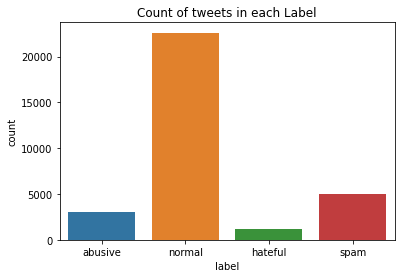

In [129]:
# Visualizing the tweet count in each label category

sns.countplot('label',data=EDA_df).set(title = 'Count of tweets in each Label')

Creating a wordcloud of top words. As expected with a dataset like twitter, a lot of the words don't make sense, but as long as it is aligned with our expectation, there is no cause for worry

In [77]:
def wordcloud(text,stopwordss):
    # Set figure size
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black',
                        colormap='rainbow', collocations=False).generate(text)
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()    

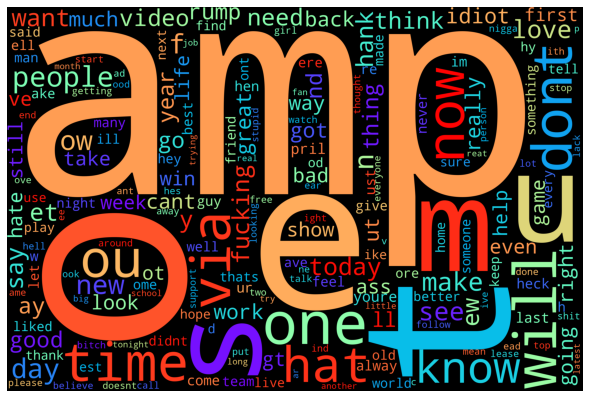

In [78]:
text = " ".join(cat for cat in EDA_df.tweet)
wordcloud(text,stpwords)

We are now going to take a look at some of the Meta features of the Dataset. With any text based dataset, meta features help us see patterns that we may not see at first glance

In [62]:
#word count
EDA_df['word_count'] = EDA_df['tweet'].apply(lambda x: len(str(x).split()))

#Unique word count
EDA_df['unique_word_count'] = EDA_df['tweet'].apply(lambda x: len(set(str(x).split())))

#Stop Word Count
EDA_df['stop_word_count'] = EDA_df['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in stpwords]))

#Mean Word Length
EDA_df['mean_word_length'] = EDA_df['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Character Count
EDA_df['char_count'] = EDA_df['tweet'].apply(lambda x: len(str(x)))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


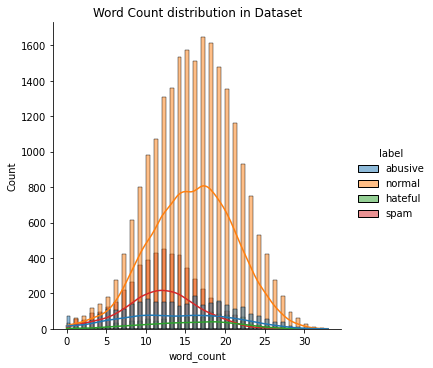

In [68]:
sns.displot(data = EDA_df, x = 'word_count', hue = 'label', kde=True).set(title='Word Count distribution in Dataset')

We can see above that mostly tweets with higher word counts tend to be Normal, and abusive and hateful tweets tend to be shorter with an average of 10-12 words per tweet

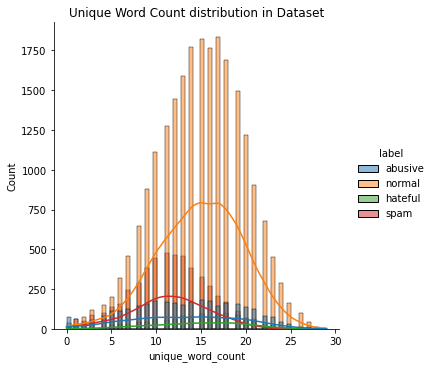

In [69]:
sns.displot(data = EDA_df, x = 'unique_word_count', hue = 'label', kde=True).set(title='Unique Word Count distribution in Dataset')

We are seeing similar trends in the above chart where mostly tweets with higher unique word counts tend to be Normal, and abusive and hateful tweets tend to be shorter with an average of 10-12 words per tweet

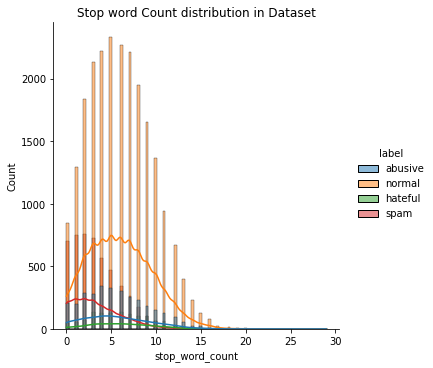

In [76]:
sns.displot(data = EDA_df, x = 'stop_word_count', hue = 'label', kde=True).set(title='Stop word Count distribution in Dataset')

(0.0, 10.0)

<Figure size 432x288 with 0 Axes>

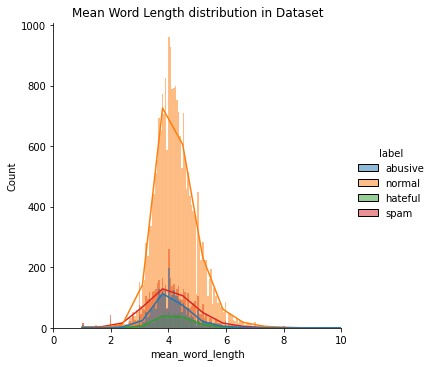

In [75]:
plt.clf()
sns.displot(data = EDA_df, x = 'mean_word_length', hue = 'label', kde=True).set(title='Mean Word Length distribution in Dataset')
plt.xlim(0,10)

This is one meta feature that is not giving us much of a pattern to understand our data

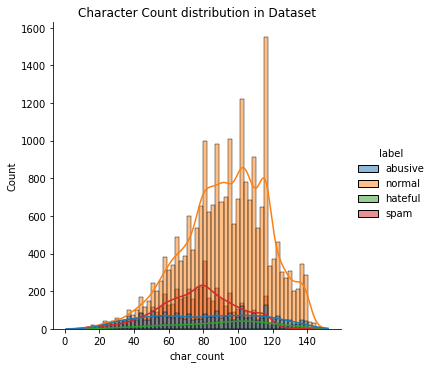

In [72]:
sns.displot(data = EDA_df, x = 'char_count', hue = 'label', kde=True).set(title='Character Count distribution in Dataset')

Since tweets are limited to 140 characters, we can see the clear trend that there are rarely any not normal tweets that use up the entire 140 characters.

In [108]:
#Function to encode the target y to One Hot Encoding or Label Encoding based on the Parameter
def target_encoder(y_train,y_test,encoder):
    if encoder == 'OH':
        encoder = preprocessing.OneHotEncoder()
        encoder.fit(y_train.values.reshape(-1,1))
        columns = encoder.categories_[0].tolist()
        print(encoder.get_params())
        y_train = encoder.transform(y_train.values.reshape(-1,1)).toarray()
        y_test = encoder.transform(y_test.values.reshape(-1,1)).toarray()
    elif encoder == 'Label':
        lEncoder = preprocessing.LabelEncoder()
        lEncoder.fit(y_train)
        print(lEncoder.get_params())
        y_train = lEncoder.transform(y_train)
        y_test = lEncoder.transform(y_test)
    return y_train, y_test

# A more thorough clean_message function that cleans the tweets from special characters but also removes punctuations and stop words
def clean_message(text,preprocessor):
    text = re.sub("'", "", text) # to avoid removing contractions in english
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\'s', '', text)
    text = re.sub(r'<br />', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)
    text = text.lower()
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed) if word not in stpwords])
    if preprocessor == 'Lemmatize':
        text = " ".join([lemmatizer.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    elif preprocessor == 'Stem':
        text = " ".join([stemmer.stem(word) for word in re.split('\W+', text_cleaned)])
    text = text.strip()
    return text

# Function uses word to vec dictionary to embed the x input to vectors
def word2Vec_encoding(x_train,y_train):
    temp = list(x_train)
    corpus = []
    for sent in temp:
        sent_vec = []
        for word in sent.split():
            try:
                sent_vec.append(w2v_dictionary[word])
            except:
                pass
        if len(sent_vec) >0:
            corpus.append(sent_vec)
        else:
            idx = x_train[x_train == sent].index[0]
            y_train.drop(index = idx,inplace = True)
            
    return corpus, y_train

# Function uses glove dictionary to embed to embed x inputs using the dictionary values
def glove_encoding(x_train,y_train):
    temp = list(x_train)
    corpus = []
    for sent in temp:
        sent_vec = []
        for word in sent.split():
            try:
                sent_vec.append(glove_dictionary[word])
            except:
                pass
        if len(sent_vec) >0:
            corpus.append(sent_vec)
        else:
            idx = x_train[x_train == sent].index[0]
            y_train.drop(index = idx,inplace = True)
            
    return corpus, y_train

# Function below takes in Embedding method as a parameter and performs either count vectorizer transform or TFIDF transform or GLOVE or W2V based on max_words parameter
def embedding(x_train,x_test,y_train,y_test,method,max_words):
    if method == 'TFIDF':
        
        vectorizer = TfidfVectorizer(max_features = max_words)
        vectorizer.fit(x_train)
        x_train_embeds = vectorizer.transform(x_train).toarray()
        x_test_embeds = vectorizer.transform(x_test).toarray()
        
        return x_train_embeds,x_test_embeds,y_train,y_test, []

    elif method == 'COUNT':
        
        vectorizer = CountVectorizer(max_features = max_words)
        vectorizer.fit(x_train)
        x_train_embeds = vectorizer.transform(x_train).toarray()
        x_test_embeds = vectorizer.transform(x_test).toarray()
        
        return x_train_embeds,x_test_embeds,y_train,y_test, []
    
    elif method == 'GLOVE':
        
        max_words = 20000
        # Max number of words in each tweet.
        max_seq = max(x_train.apply(lambda x:len(x)))
        
        tokenizer = Tokenizer(num_words=max_words,oov_token="<OOV>")
        tokenizer.fit_on_texts(x_train.values)
        word_index = tokenizer.word_index
        vocabulary = list(word_index.keys())
        x_train = tokenizer.texts_to_sequences(x_train)
        x_test = tokenizer.texts_to_sequences(x_test)
        x_train = pad_sequences(x_train, maxlen = 200)
        x_test = pad_sequences(x_test, maxlen = 200)
        
        embedding_matrix = np.zeros((len(vocabulary), 200))

        for word,index in word_index.items():
            try: 
                embedding_matrix[index,:] = glove_dictionary[word]
            except:
                pass
        return x_train, x_test,y_train,y_test, embedding_matrix
    
    elif method == 'W2V':
        max_words = 20000
        # Max number of words in each tweet.
        max_seq = max(x_train.apply(lambda x:len(x)))
        
        tokenizer = Tokenizer(num_words=max_words,oov_token="<OOV>")
        tokenizer.fit_on_texts(x_train.values)
        word_index = tokenizer.word_index
        vocabulary = list(word_index.keys())
        x_train = tokenizer.texts_to_sequences(x_train)
        x_test = tokenizer.texts_to_sequences(x_test)
        x_train = pad_sequences(x_train, maxlen = 200)
        x_test = pad_sequences(x_test, maxlen = 200)
        
        embedding_matrix = np.zeros((len(vocabulary), 200))

        for word,index in word_index.items():
            try: 
                embedding_matrix[index,:] = w2v_dictionary[word]
            except:
                pass
        return x_train, x_test,y_train,y_test, embedding_matrix
    
    elif method == 'W2V_NB':
        x_train_embeds,y_train = word2Vec_encoding(x_train,y_train)
        x_test_embeds, y_test = word2Vec_encoding(x_test,y_test)
        x_train_embeds = [np.array(x).mean(axis = 0) for x in x_train_embeds]
        x_test_embeds = [np.array(x).mean(axis = 0) for x in x_test_embeds]
        
        return x_train_embeds,x_test_embeds, y_train, y_test, []
    
    elif method == 'GLOVE_NB':
        x_train_embeds,y_train = glove_encoding(x_train,y_train)
        x_test_embeds, y_test = glove_encoding(x_test,y_test)
        x_train_embeds = [np.array(x).mean(axis = 0) for x in x_train_embeds]
        x_test_embeds = [np.array(x).mean(axis = 0) for x in x_test_embeds]
        
        return x_train_embeds,x_test_embeds, y_train, y_test, []

In [127]:
#Function takes in dataframe input, preprocessing method, embedding method, target encoding and returns x_train embedded, x_test embedded, y_train encoded and y_test encoded and embdedding matrix (for W2V and GLOVE)
def prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words):
    data = df.copy(deep=True)
    print("\nCLEANING DATASET")
    print('Shape of dataset before cleaning', data.shape)
    
    data['tweet'] = data['tweet'].apply(clean_message,preprocessor = preprocessing_method)
    data = data[data['tweet'].apply(lambda x: str(x)!= "")]
    data.drop_duplicates(['tweet'],inplace = True,keep = 'first')
    
    print('Shape of dataset after cleaning', data.shape)
    
    print("\nTRAIN - TEST SPLIT")
    
    x = data.iloc[:,1]
    y = data.iloc[:,2]
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=100)
    print('Shape of x_train',x_train.shape)
    print('Shape of x_test',x_test.shape)
    print('Shape of y_train',y_train.shape)
    print('Shape of x_test',y_test.shape)
    
    print("\nEMBEDDING TEXTS")
    
    x_train_embeds, x_test_embeds, y_train, y_test,embedding_matrix = embedding(x_train,x_test,y_train,y_test,embedding_method, max_words)
    
    print("\nShape after embeddings")
    
    print('Shape of x_train :',np.array(x_train_embeds).shape)
    print('Shape of x_test :',np.array(x_test_embeds).shape)
    print('Shape of y_train :',np.array(y_train.shape).shape)
    print('Shape of x_test :',np.array(y_test.shape).shape)
    
    print("Encoding Target variable using",target_encoding,"encoding")
    y_train_enc,y_test_enc = target_encoder(y_train,y_test,target_encoding)
    
    print("\nShape of target after encoding")
    print("size of y_train: ",len(y_train_enc))
    print("size of y_test: ",len(y_test_enc))
    return x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix
   

In [ ]:
#Function takes in the trained model and displays the confusion matrix
def DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc):
    mat = confusion_matrix(preds, y_test_enc)
    axis_labels=['abusive', 'hateful', 'normal', 'spam']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,xticklabels=axis_labels, yticklabels=axis_labels)
    plt.title(f"{model} with {embedding_method} ({preprocessing_method} based)")
    plt.xlabel('Predicted Categories')
    plt.ylabel('True Categories')
    plt.show() 

###Pre Processing Methods###

* **Stemming** : Stemming is a natural language processing technique that lowers inflection in words to their root forms
* **Lemmatization** : Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning.

###Embedding Methods###

* Count Vectorizer : 
CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.
* TF IDF : Term Frequency - Inverse Delay Frequency is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.
* Word2Vec : Word2Vec model is used for Word representations in Vector Space which is founded by Tomas Mikolov and a group of the research teams from Google in 2013. It is a neural network model that attempts to explain the word embeddings based on a text corpus. These models work using context.
* GLOVE :  GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

###Model - 1 : Naive Bayes Classifier###
Naïve Bayes Classifier is one of the simple and most effective Classification algorithms which helps in building the fast machine learning models that can make quick predictions. It is a probabilistic classifier, which means it predicts on the basis of the probability of an object.

Naive Bayes algorithms are mostly used in sentiment analysis, spam filtering, recommendation systems etc. They are fast and easy to implement but their biggest disadvantage is that the requirement of predictors to be independent.

####Combination 1 - Naive Bayes + Stemming + CountVectorizer####

In [ ]:
Results_NB_DF = pd.DataFrame()


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25264, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25264
size of y_test:  6316

TRAINING MULTINOMIAL NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       603
           1       0.41      0.17      0.24       245
           2       0.82      0.84      0.83      4462
           3       0.45      0.48      0.46      1006

    accuracy                           0.74      6316
   macro avg       0.59      0.54      0.55      6316
weighted avg       0.73      0.74      0.74      

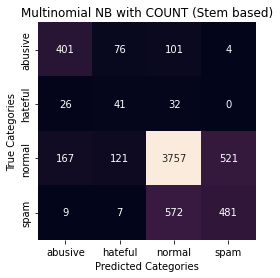

In [ ]:
preprocessing_method = 'Stem'
embedding_method = 'COUNT' 
target_encoding = 'Label'
max_words = 1000
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
print("\nTRAINING MULTINOMIAL NAIVE BAYES")
NB_Stem_CV = MultinomialNB()
NB_Stem_CV.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Stem_CV.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Stem_CV', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

####Combination 2 - Naive Bayes + Lemmatization + CountVectorizer####


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25263, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25263
size of y_test:  6316

TRAINING MULTINOMIAL NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       598
           1       0.39      0.15      0.21       253
           2       0.82      0.86      0.84      4445
           3       0.47      0.45      0.46      1020

    accuracy                           0.75      6316
   macro avg       0.60      0.53      0.55      6316
weighted avg       0.73      0.75      0.74      

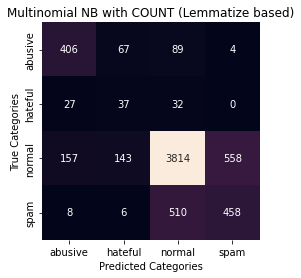

In [ ]:
preprocessing_method = 'Lemmatize'
embedding_method = 'COUNT' 
target_encoding = 'Label'
max_words = 1000
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
print("\nTRAINING MULTINOMIAL NAIVE BAYES")
NB_Lem_CV = MultinomialNB()
NB_Lem_CV.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Lem_CV.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Lem_CV', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

####Combination 3 - Naive Bayes + Stemming + TFIDF####


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25264, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25264
size of y_test:  6316

TRAINING MULTINOMIAL NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.45      0.58       603
           1       0.83      0.02      0.04       245
           2       0.77      0.96      0.86      4462
           3       0.58      0.22      0.32      1006

    accuracy                           0.76      6316
   macro avg       0.74      0.41      0.45      6316
weighted avg       0.74      0.76      0.71      

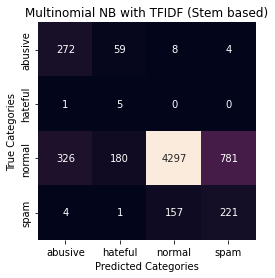

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'TFIDF' 
target_encoding = 'Label'
max_words = 1000
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)

print("\nTRAINING MULTINOMIAL NAIVE BAYES")
NB_Stem_TFIDF = MultinomialNB()
NB_Stem_TFIDF.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Stem_TFIDF.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Stem_TFIDF', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

####Combination 4 - Naive Bayes + Stemming + TFIDF####


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25263, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25263
size of y_test:  6316

TRAINING MULTINOMIAL NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.47      0.60       598
           1       0.88      0.03      0.05       253
           2       0.77      0.96      0.85      4445
           3       0.58      0.23      0.33      1020

    accuracy                           0.76      6316
   macro avg       0.76      0.42      0.46      6316
weighted avg       0.75      0.76      0.71      

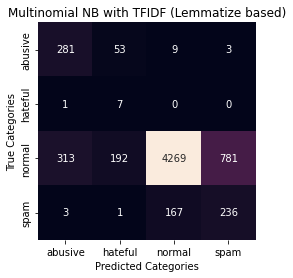

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'TFIDF' 
target_encoding = 'Label'
max_words = 1000
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)

print("\nTRAINING MULTINOMIAL NAIVE BAYES")
NB_Lem_TFIDF = MultinomialNB()
NB_Lem_TFIDF.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Lem_TFIDF.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Lem_TFIDF', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

####Combination 5 - Gaussian Naive Bayes + Lemmatization + Word2Vec####


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25135, 300)
Shape of x_test : (6280, 300)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25135
size of y_test:  6280

TRAINING GAUSSIAN NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       595
           1       0.17      0.26      0.20       251
           2       0.82      0.69      0.75      4427
           3       0.35      0.53      0.42      1007

    accuracy                           0.64      6280
   macro avg       0.46      0.51      0.48      6280
weighted avg       0.69      0.64      0.66      6280


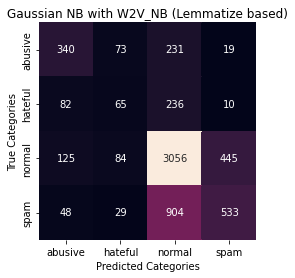

In [ ]:
max_words = 1000
preprocessing_method = 'Lemmatize' 
embedding_method = 'W2V_NB' 
target_encoding = 'Label'
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)

print("\nTRAINING GAUSSIAN NAIVE BAYES")
NB_Lem_W2V = GaussianNB()
NB_Lem_W2V.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Lem_W2V.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Lem_W2V', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

####Combination 6 - Gaussian Naive Bayes + Stemming + Word2Vec####


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25127, 300)
Shape of x_test : (6282, 300)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25127
size of y_test:  6282

TRAINING GAUSSIAN NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.60      0.55      0.57       600
           1       0.16      0.25      0.19       243
           2       0.82      0.70      0.76      4446
           3       0.34      0.52      0.41       993

    accuracy                           0.64      6282
   macro avg       0.48      0.51      0.48      6282
weighted avg       0.70      0.64      0.66      6282


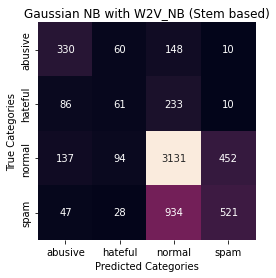

In [ ]:
max_words = 1000
preprocessing_method = 'Stem' 
embedding_method = 'W2V_NB' 
target_encoding = 'Label'
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)

print("\nTRAINING GAUSSIAN NAIVE BAYES")
NB_Stem_W2V = GaussianNB()
NB_Stem_W2V.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Stem_W2V.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Stem_W2V', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])


####Combination 7 - Gaussian Naive Bayes + Stemming + GLOVE####


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25182, 200)
Shape of x_test : (6301, 200)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25182
size of y_test:  6301

TRAINING GAUSSIAN NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       602
           1       0.14      0.29      0.18       244
           2       0.82      0.64      0.72      4451
           3       0.33      0.55      0.41      1004

    accuracy                           0.60      6301
   macro avg       0.45      0.51      0.46      6301
weighted avg       0.69      0.60      0.63      6301


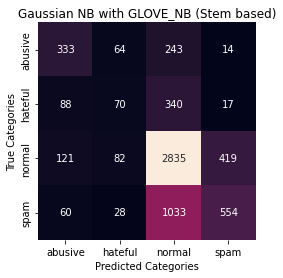

In [ ]:
max_words = 20000
preprocessing_method = 'Stem' 
embedding_method = 'GLOVE_NB' 
target_encoding = 'Label'
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'


x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)

print("\nTRAINING GAUSSIAN NAIVE BAYES")
NB_Stem_GLOVE = GaussianNB()
NB_Stem_GLOVE.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Stem_GLOVE.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Stem_GLOVE', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

####Combination 8 - Gaussian Naive Bayes + Lemmatization + GLOVE####


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25172, 200)
Shape of x_test : (6300, 200)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25172
size of y_test:  6300

TRAINING GAUSSIAN NAIVE BAYES
PREDICTING
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.42      0.54      0.47       597
           1       0.12      0.35      0.18       252
           2       0.82      0.59      0.69      4438
           3       0.34      0.56      0.43      1013

    accuracy                           0.57      6300
   macro avg       0.43      0.51      0.44      6300
weighted avg       0.68      0.57      0.60      6300


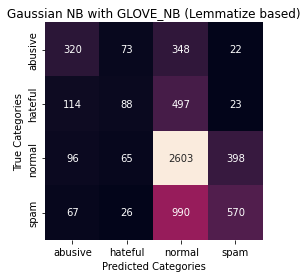

In [ ]:
max_words = 20000
preprocessing_method = 'Lemmatize' 
embedding_method = 'GLOVE_NB' 
target_encoding = 'Label'
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)

print("\nTRAINING GAUSSIAN NAIVE BAYES")
NB_Lem_GLOVE = GaussianNB()
NB_Lem_GLOVE.fit(x_train_embeds, y_train_enc)

print("PREDICTING")
preds = NB_Lem_GLOVE.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix(model,embedding_method,preprocessing_method,preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Lem_GLOVE', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

We will now take a look at the results we have so far

In [ ]:
Results_NB_DF.head(10)

,ModelName,Precision,Recall,F-1Score
0,NB_Stem_CV,0.734803,0.740975,0.735691
0,NB_Lem_CV,0.733198,0.746517,0.737260
0,NB_Stem_TFIDF,0.743577,0.759183,0.711483
0,NB_Lem_TFIDF,0.746430,0.758866,0.712809
0,NB_Lem_W2V,0.692319,0.635987,0.656589
0,NB_Stem_W2V,0.698390,0.643585,0.664192
0,NB_Stem_GLOVE,0.685909,0.601809,0.630187
0,NB_Lem_GLOVE,0.679972,0.568413,0.603123


The model with High Recall and Better Precision than most,is Multinomial NB_Stem_TFIDF. We will now hyperparameter tune a Naive Bayes model, and use those preprocessing and embedding techniques with the tuned model to see how well the model is now doing.

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'TFIDF' 
target_encoding = 'Label'
max_words = 1000
if embedding_method in ['COUNT','TFIDF']:
    model = 'Multinomial NB' 
elif embedding_method in ['GLOVE_NB','W2V_NB']:
    model = 'Gaussian NB'
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25264, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25264
size of y_test:  6316


Since tuning of the model takes a bit of time, we will be saving the tuned model to a pickle file and then access it back for future runs.

In [ ]:
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)
#params_Gaussian_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
params_Multinomial_NB = {'alpha': np.arange(0,10,1/10)}
model=MultinomialNB()
# Tuned_NB = GridSearchCV(estimator=model, 
#                      param_grid=params_Multinomial_NB, 
#                      cv=cv_method,
#                      verbose=1, 
#                      scoring='recall_weighted')

# Tuned_NB.fit(x_train_embeds, y_train_enc);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warning

In [ ]:
# with open('NB_Optimized', 'wb') as files:
#     pickle.dump(Tuned_NB, files)

In [ ]:
# Reading data back from pickle file saved in Drive
with open('NB_Optimized', 'rb') as f:
    Optimized_model_NB = pickle.load(f)

Below we can see the performance of the model upon changing the parameter alpha for Naive Bayes

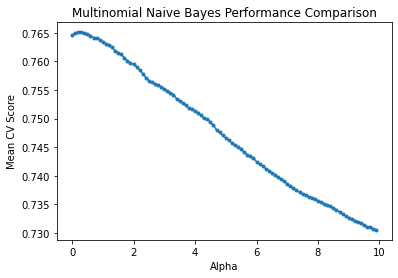

In [ ]:
results_hyperparameter_tuning_NB = pd.DataFrame(Optimized_model_NB.cv_results_['params'])
results_hyperparameter_tuning_NB['test_score'] = Optimized_model_NB.cv_results_['mean_test_score']
plt.plot(results_hyperparameter_tuning_NB['alpha'], results_hyperparameter_tuning_NB['test_score'], marker = '.')    
plt.xlabel('Alpha')
plt.ylabel("Mean CV Score")
plt.title("Multinomial Naive Bayes Performance Comparison")
plt.show()

####Combination 9 - Optimized Naive Bayes + Stemming + TFIDF####

In [ ]:
#Predicting using Optimized model
print("PREDICTING WITH OPTIMIZED MODEL")
preds = Optimized_model_NB.predict(x_test_embeds)
        
print('CLASSIFICATION REPORT')
print(classification_report(y_test_enc,preds))

DisplayConfusionMatrix('Optimized Multinomial NB','TFIDF','Stemming',preds,y_test_enc)

Metrics = pd.DataFrame({'ModelName':'NB_Stem_TFIDF_Optimized', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_NB_DF = pd.concat([Results_NB_DF,Metrics])

In [ ]:
Results_NB_DF

,ModelName,Precision,Recall,F-1Score
0,NB_Stem_CV,0.734803,0.740975,0.735691
0,NB_Lem_CV,0.733198,0.746517,0.737260
0,NB_Stem_TFIDF,0.743577,0.759183,0.711483
0,NB_Lem_TFIDF,0.746430,0.758866,0.712809
0,NB_Lem_W2V,0.692319,0.635987,0.656589
0,NB_Stem_W2V,0.698390,0.643585,0.664192
0,NB_Stem_GLOVE,0.685909,0.601809,0.630187
0,NB_Lem_GLOVE,0.679972,0.568413,0.603123
0,NB_Stem_TFIDF_Optimized,0.734831,0.758391,0.716159


We can see that the optimized model is performing on par with the non-optimized default Stemming + TFIDF combination.

###Visualizing Model Performance###

Below plot helps us see the performance metrics, namely Precision, Recall and F-1 score for the 9 Naive Bayes model that we trained, side-by-side. 

In [ ]:

fig = go.Figure(data=[
    go.Bar(name='Precision', x=Results_NB_DF['ModelName'], y=Results_NB_DF['Precision']),
    go.Bar(name='Recall', x=Results_NB_DF['ModelName'], y=Results_NB_DF['Recall']),
    go.Bar(name='F1-Score', x=Results_NB_DF['ModelName'], y=Results_NB_DF['F-1Score'])
])
fig.update_layout(title = 'Naive Bayes Metrics Results Plot')
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(range=[0.5,0.8], dtick=0.01)
fig.show()

We can infer that the Optimized model stands out among all of them. Moreover, we can see that Naive Bayes performs best with Embedding techniques such as CV and TFIDF rather that W2V or GLOVE in the case of our dataset.

### Model - 2 Support Vector Machines (SVM) ###
Support vector machines is an algorithm that determines the best decision boundary between vectors that belong to a given group (or category) and vectors that do not belong to it.

It can be applied to any kind of vectors which encode any kind of data. This means that in order to leverage the power of svm text classification, texts have to be transformed into vectors. 

In [ ]:
Results_SVM_DF = pd.DataFrame()

In [ ]:
#Function to take in trained SVM, x_test and y_test and print metrics
def SVM_predict(SVM, x_test_embeds, y_test_enc,embedding_method,preprocessing_method):
    preds = SVM.predict(x_test_embeds)
    print(classification_report(y_test_enc,preds))
    mat = confusion_matrix(preds, y_test_enc)
    axis_labels=['abusive', 'hateful', 'normal', 'spam']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,xticklabels=axis_labels, yticklabels=axis_labels)
    plt.title(f"SVM with {embedding_method} ({preprocessing_method} based)")
    plt.xlabel('Predicted Categories')
    plt.ylabel('True Categories')
    plt.show() 
    return preds,y_test_enc

In [128]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'COUNT' 
target_encoding = 'Label'
max_words = 1000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc, embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Lem_CV = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Lem_CV.fit(x_train_embeds, y_train_enc)

# with open('SVM_Lem_CV', 'wb') as files:
#     pickle.dump(SVM_model_Lem_CV, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25263, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25263
size of y_test:  6316


####Combination 10 - SVM + Lemmatization + Count Vectorizer####

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       598
           1       0.52      0.17      0.26       253
           2       0.78      0.97      0.86      4445
           3       0.65      0.10      0.17      1020

    accuracy                           0.77      6316
   macro avg       0.68      0.48      0.50      6316
weighted avg       0.75      0.77      0.71      6316



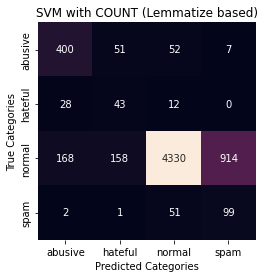

In [ ]:
with open('SVM_Lem_CV','rb') as f:
  SVM_Lem_CV = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Lem_CV,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Lem_CV', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

####Combination 11 - SVM + Stemming + Count Vectorizer####

In [ ]:
preprocessing_method = 'Stem'
embedding_method = 'COUNT' 
target_encoding = 'Label'
max_words = 1000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc, embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Stem_CV = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Stem_CV.fit(x_train_embeds, y_train_enc)

# with open('SVM_Stem_CV', 'wb') as files:
#     pickle.dump(SVM_model_Stem_CV, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25264, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25264
size of y_test:  6316


              precision    recall  f1-score   support

           0       0.27      0.15      0.19       603
           1       0.05      0.02      0.03       245
           2       0.71      0.91      0.80      4462
           3       0.24      0.04      0.07      1006

    accuracy                           0.66      6316
   macro avg       0.32      0.28      0.27      6316
weighted avg       0.57      0.66      0.59      6316



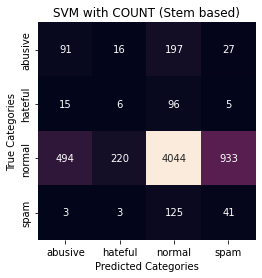

In [ ]:
#Pulling in model from drive
with open('SVM_Stem_CV','rb') as f:
  SVM_Stem_CV = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Stem_CV,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Stem_CV', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

####Combination 12 - SVM + Lemmatization + TFIDF####

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'TFIDF' 
target_encoding = 'Label'
max_words = 1000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc, embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Lem_TFIDF = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Lem_TFIDF.fit(x_train_embeds, y_train_enc)

# with open('SVM_Lem_TFIDF', 'wb') as files:
#     pickle.dump(SVM_model_Lem_TFIDF, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25263, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25263
size of y_test:  6316


              precision    recall  f1-score   support

           0       0.13      0.07      0.09       598
           1       0.00      0.00      0.00       253
           2       0.70      0.93      0.80      4445
           3       0.18      0.02      0.04      1020

    accuracy                           0.66      6316
   macro avg       0.25      0.26      0.23      6316
weighted avg       0.54      0.66      0.58      6316



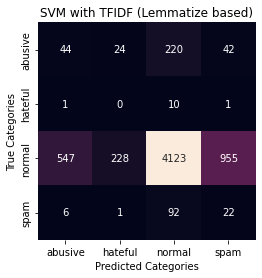

In [ ]:
with open('SVM_Lem_TFIDF','rb') as f:
  SVM_Lem_TFIDF = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Lem_TFIDF,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Lem_TFIDF', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

####Combination 13 - SVM + Stemming + TFIDF####

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'TFIDF' 
target_encoding = 'Label'
max_words = 1000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Stem_TFIDF = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Stem_TFIDF.fit(x_train_embeds, y_train_enc)

# with open('SVM_Stem_TFIDF', 'wb') as files:
#     pickle.dump(SVM_model_Stem_TFIDF, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25264, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25264
size of y_test:  6316


              precision    recall  f1-score   support

           0       0.04      0.02      0.03       603
           1       0.01      0.00      0.01       245
           2       0.70      0.91      0.79      4462
           3       0.23      0.03      0.06      1006

    accuracy                           0.65      6316
   macro avg       0.25      0.24      0.22      6316
weighted avg       0.54      0.65      0.57      6316



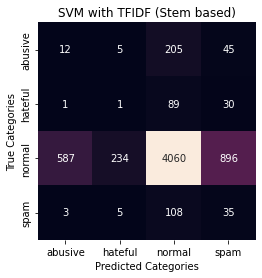

In [ ]:
with open('SVM_Stem_TFIDF','rb') as f:
  SVM_Stem_TFIDF = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Stem_TFIDF,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Stem_TFIDF', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

####Combination 14 - SVM + Lemmatization + W2V####

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'W2V_NB'
target_encoding = 'Label'
max_words = 1000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Lem_W2V = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Lem_W2V.fit(x_train_embeds, y_train_enc)

# with open('SVM_Lem_W2V', 'wb') as files:
#     pickle.dump(SVM_model_Lem_W2V, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25135, 300)
Shape of x_test : (6280, 300)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25135
size of y_test:  6280


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      0.49      0.59       595
           1       0.63      0.07      0.12       251
           2       0.75      0.99      0.85      4427
           3       0.00      0.00      0.00      1007

    accuracy                           0.75      6280
   macro avg       0.53      0.39      0.39      6280
weighted avg       0.62      0.75      0.66      6280



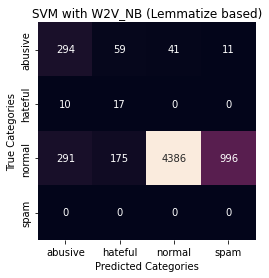

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
with open('SVM_Lem_W2V','rb') as f:
  SVM_Lem_W2V = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Lem_W2V,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Lem_W2V', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

####Combination 15 - SVM + Stemming + W2V####

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'W2V_NB' 
target_encoding = 'Label'
max_words = 1000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc, embedding_matrix= prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Stem_W2V = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Stem_W2V.fit(x_train_embeds, y_train_enc)

# with open('SVM_Stem_W2V', 'wb') as files:
#     pickle.dump(SVM_model_Stem_W2V, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25127, 300)
Shape of x_test : (6282, 300)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25127
size of y_test:  6282


              precision    recall  f1-score   support

           0       0.77      0.53      0.63       600
           1       0.70      0.09      0.15       243
           2       0.76      0.99      0.86      4446
           3       0.00      0.00      0.00       993

    accuracy                           0.76      6282
   macro avg       0.56      0.40      0.41      6282
weighted avg       0.64      0.76      0.67      6282



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


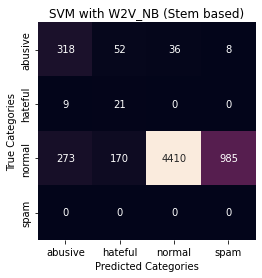

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
with open('SVM_Stem_W2V','rb') as f:
  SVM_Stem_W2V = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Stem_W2V,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Stem_W2V', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

####Combination 16 - SVM + Lemmatization + GLOVE####

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'GLOVE_NB' 
target_encoding = 'Label'
max_words = 20000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Lem_GLOVE = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Lem_GLOVE.fit(x_train_embeds, y_train_enc)

# with open('SVM_Lem_GLOVE', 'wb') as files:
#     pickle.dump(SVM_model_Lem_GLOVE, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25172, 200)
Shape of x_test : (6300, 200)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25172
size of y_test:  6300


              precision    recall  f1-score   support

           0       0.72      0.44      0.55       597
           1       0.00      0.00      0.00       252
           2       0.74      0.99      0.85      4438
           3       0.00      0.00      0.00      1013

    accuracy                           0.74      6300
   macro avg       0.37      0.36      0.35      6300
weighted avg       0.59      0.74      0.65      6300



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


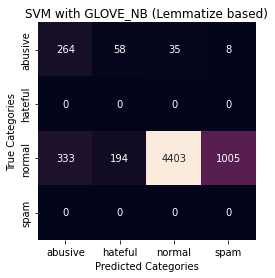

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
with open('SVM_Lem_GLOVE','rb') as f:
  SVM_Lem_GLOVE = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Lem_GLOVE,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Lem_GLOVE', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

####Combination 17 - SVM + Stemming + GLOVE####

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'GLOVE_NB' 
target_encoding = 'Label'
max_words = 20000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)
# SVM_model_Stem_GLOVE = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM_model_Stem_GLOVE.fit(x_train_embeds, y_train_enc)

# with open('SVM_Stem_GLOVE', 'wb') as files:
#     pickle.dump(SVM_model_Stem_GLOVE, files)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

TRAIN - TEST SPLIT
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25182, 200)
Shape of x_test : (6301, 200)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25182
size of y_test:  6301


              precision    recall  f1-score   support

           0       0.77      0.51      0.62       602
           1       0.00      0.00      0.00       244
           2       0.75      0.99      0.85      4451
           3       0.00      0.00      0.00      1004

    accuracy                           0.75      6301
   macro avg       0.38      0.38      0.37      6301
weighted avg       0.60      0.75      0.66      6301



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


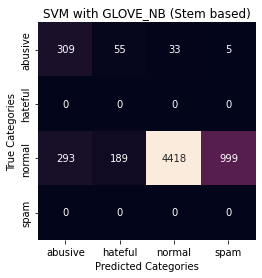

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
with open('SVM_Stem_GLOVE','rb') as f:
  SVM_Stem_GLOVE = pickle.load(f)

preds,y_test_enc = SVM_predict(SVM_Stem_GLOVE,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Stem_GLOVE', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

We will now take a results we have so far, and pick the best performing ablation setting we have to use for the hyperparameter tuned version of the SVM

In [ ]:
Results_SVM_DF.head(10)

,ModelName,Precision,Recall,F-1Score
0,SVM_Lem_CV,0.746602,0.771374,0.714424
0,SVM_Stem_CV,0.568130,0.662128,0.593734
0,SVM_Lem_TFIDF,0.537739,0.663236,0.578740
0,SVM_Stem_TFIDF,0.538021,0.650412,0.572737
0,SVM_Lem_W2V,0.622645,0.747930,0.662418
0,SVM_Stem_W2V,0.635062,0.755969,0.672842
0,SVM_Lem_GLOVE,0.591147,0.740794,0.650038
0,SVM_Stem_GLOVE,0.602486,0.750198,0.661873


We can see that the model with the Best Recall and High Precision is SVM_Lem_CV. We will hyperparameter tune with those Ablation Settings, i.e. Preprocessing method as Lemmatization and Embedding method as Count Vectorizer

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'COUNT'
target_encoding = 'Label'
max_words = 1000

x_train_embeds,y_train_enc,x_test_embeds,y_test_enc, embedding_matrix = prepare_data(df, preprocessing_method, embedding_method, target_encoding, max_words)


CLEANING DATASET
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

TRAIN - TEST SPLIT
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

EMBEDDING TEXTS

Shape after embeddings
Shape of x_train : (25263, 1000)
Shape of x_test : (6316, 1000)
Shape of y_train : (1,)
Shape of x_test : (1,)
Encoding Target variable using Label encoding
{}

Shape of target after encoding
size of y_train:  25263
size of y_test:  6316


In [ ]:
cv_method = StratifiedKFold(n_splits=3)

param_grid= {'C': [1,10,100],'gamma': [1,0.1,0.01],'kernel': ['rbf']}   
# SVM_Tuned = RandomizedSearchCV(SVC(), param_grid, cv=v_method, scoring = 'recall_weighted', verbose= 3)  
# SVM_Tuned.fit(x_train_embeds, y_train_enc)
# with open('SVM_Optimized', 'wb') as files:
#     pickle.dump(SVM_Tuned, files)

In [ ]:
#Loading in Optimized model saved to drive from previous step
with open('SVM_Optimized', 'rb') as f:
    Optimized_model_SVM = pickle.load(f)

####Combination 18 - SVM + Lemmatization + Count Vectorizer ####

Printing metrics for the Optimized model

              precision    recall  f1-score   support

           0       0.82      0.59      0.68       598
           1       0.65      0.12      0.20       253
           2       0.76      0.98      0.86      4445
           3       0.68      0.08      0.14      1020

    accuracy                           0.77      6316
   macro avg       0.73      0.44      0.47      6316
weighted avg       0.75      0.77      0.70      6316



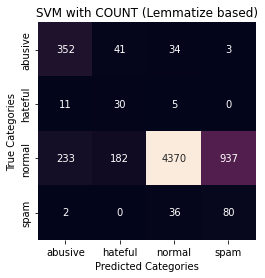

In [ ]:
preds,y_test_enc = SVM_predict(Optimized_model_SVM,x_test_embeds,y_test_enc,embedding_method,preprocessing_method)

Metrics = pd.DataFrame({'ModelName':'SVM_Lem_CV_Optimized', 'Precision':precision_score(y_test_enc,preds,average='weighted'),'Recall':recall_score(y_test_enc,preds,average='weighted'),'F-1Score':f1_score(y_test_enc,preds,average='weighted')},index = [0])
Results_SVM_DF = pd.concat([Results_SVM_DF,Metrics])

In [ ]:
Results_SVM_DF

,ModelName,Precision,Recall,F-1Score
0,SVM_Lem_CV,0.746602,0.771374,0.714424
0,SVM_Stem_CV,0.568130,0.662128,0.593734
0,SVM_Lem_TFIDF,0.537739,0.663236,0.578740
0,SVM_Stem_TFIDF,0.538021,0.650412,0.572737
0,SVM_Lem_W2V,0.622645,0.747930,0.662418
0,SVM_Stem_W2V,0.635062,0.755969,0.672842
0,SVM_Lem_GLOVE,0.591147,0.740794,0.650038
0,SVM_Stem_GLOVE,0.602486,0.750198,0.661873
0,SVM_Lem_CV_Optimized,0.750599,0.765041,0.700573


We can see that Optimized model has higher precision than the base model with the same preprocessing and embedding settings.

In the below plot we will try to compare the three key metrics side by side to undestand how the ablation settings work with the same base model

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Precision', x=Results_SVM_DF['ModelName'], y=Results_SVM_DF['Precision']),
    go.Bar(name='Recall', x=Results_SVM_DF['ModelName'], y=Results_SVM_DF['Recall']),
    go.Bar(name='F1-Score', x=Results_SVM_DF['ModelName'], y=Results_SVM_DF['F-1Score'])
])
fig.update_layout(title = 'Support Vector Machine Metrics Results Plot')
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(range=[0.5,0.8], dtick=0.01)
fig.show()

From the above results we can interpret that SVM with Lemmatization and Count Vectorizer is best suited for our data, we can see GLOVE and W2V embedding methods give recall values on par, but lower precision compared to the former.

### Model - 3 Long Short Term Memory (LSTM) ###

LSTM stands for Long-Short Term Memory. LSTM is a type of recurrent neural network but is better than traditional recurrent neural networks in terms of memory. Having a good hold over memorizing certain patterns LSTMs perform fairly better. As with every other NN, LSTM can have multiple hidden layers and as it passes through every layer, the relevant information is kept and all the irrelevant information gets discarded in every single cell.

If we look and other non-neural network classification techniques they are trained on multiple word as separate inputs that are just word having no actual meaning as a sentence, and while predicting the class it will give the output according to statistics and not according to meaning. That means, every single word is classified into one of the categories.

This is not the same in LSTM. In LSTM we can use a multiple word string to find out the class to which it belongs. This is very helpful while working with Natural language processing. If we use appropriate layers of embedding and encoding in LSTM, the model will be able to find out the actual meaning in input string and will give the most accurate output class.

In [ ]:
#Function to prepare data for LSTM takes in DataFrame and returns x_train embedded, y_train encoded, x_test embedded, y_test encoded and embedding matrix for GLOVE and W2V if applicable
def prepare_data_LSTM(df, preprocessing_method, embedding_method,max_words, target_encoding):
    data = df.copy(deep=True)
    print("\n### CLEANING DATASET ###")
    print('Shape of dataset before cleaning', data.shape)

    data['tweet'] = data['tweet'].apply(clean_message,preprocessor = preprocessing_method)
    data = data[data['tweet'].apply(lambda x: str(x)!= "")]
    data.drop_duplicates(['tweet'],inplace = True,keep = 'first')

    print('Shape of dataset after cleaning', data.shape)

    print("\n### TRAIN - TEST SPLIT ###")

    x = data.iloc[:,1]
    y = data.iloc[:,2]
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=100)
    print('Shape of x_train',x_train.shape)
    print('Shape of x_test',x_test.shape)
    print('Shape of y_train',y_train.shape)
    print('Shape of x_test',y_test.shape)

    print("\n### EMBEDDING TEXTS ###")

    x_train_embeds, x_test_embeds, y_train, y_test,embedding_matrix = embedding(x_train,x_test,y_train,y_test,embedding_method,max_words)

    print("\n ### Shape after embeddings ###")

    print('Shape of x_train',np.array(x_train_embeds).shape)
    print('Shape of x_test',np.array(x_test_embeds).shape)
    print('Shape of y_train',np.array(y_train.shape).shape)
    print('Shape of x_test',np.array(y_test.shape).shape)

    print("\n### ENCODING TARGET VARIABLE ###")
    y_train_enc,y_test_enc = target_encoder(y_train,y_test,target_encoding)

    print("\n ### Shape of target after encoding ###")
    print("size of y_train: ",y_train_enc.shape)
    print("size of y_test: ",y_test_enc.shape)

    return x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix

We will be using different settings for models for each of the different embedding settings, below is the one for Count Vectorizer

In [ ]:
def build_model_CV(max_words):

  model = tf.keras.Sequential()
  
  model.add(Bidirectional(LSTM(200,recurrent_dropout=0.1),input_shape = (max_words,1)))
  model.add(Dropout(0.1,seed = 100))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1,seed = 100))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Precision','AUC','Recall','accuracy'])
  return model

In [ ]:
# Function takes in xtest and ytest and returns predicted labels
def Classification_Report (x_test_embeds,y_train,y_test,lstm_model):
    preds = lstm_model.predict(x_test_embeds)
    preds = np.argmax(preds,axis = 1)
    lEncoder = preprocessing.LabelEncoder()
    lEncoder.fit(y_train)
    y_test = lEncoder.transform(y_test)
    return y_test,preds

In [ ]:
#Function plots LSTM training metrics such as Accuracy, Loss and AUC
def plot_LSTM_metrics(LSTM_model_history):
    plt.figure(figsize=(15,15))

    plt.subplot(2,2,1)
    plt.plot(LSTM_model_history.history["val_accuracy"], label="validation_accuracy", c="red", linewidth=4)
    plt.plot(LSTM_model_history.history["accuracy"], label="training_accuracy", c="green", linewidth=4)
    plt.legend()
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.grid(True)

    plt.subplot(2,2,2)
    plt.plot(LSTM_model_history.history["val_loss"], label="validation_loss", c="red", linewidth=4)
    plt.plot(LSTM_model_history.history["loss"], label="training_loss", c="green", linewidth=4)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(2,2,3)
    plt.plot(LSTM_model_history.history["val_auc"], label="validation_auc", c="red", linewidth=4)
    plt.plot(LSTM_model_history.history["auc"], label="training_auc", c="green", linewidth=4)
    plt.xlabel("Number of Epochs")
    plt.ylabel("AUC")
    plt.title("AUC")
    plt.legend()
    plt.grid(True)

    plt.suptitle("Training vs Validation metrics of model trained on an LSTM Model",fontsize=18)




    plt.show()




In [ ]:
Results_LSTM_DF = pd.DataFrame()

####Combination 19 - LSTM + Lemmatization + Count Vectorizer####

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'COUNT' 
target_encoding = 'OH'
max_words = 1000
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_LSTM(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25263, 1000)
Shape of x_test (6316, 1000)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25263, 4)
size of y_test:  (6316, 4)


Since the LSTM Models take around 5 hours to train, we have saved them into pickle files, and will be accessing them from the drive to evaluate metrics and predict values

In [ ]:
LSTM_model_Lem_CV = build_model_CV(max_words)
epochs = 10
batch_size = 128

# LSTM_model_Lem_CV_History = LSTM_model_Lem_CV.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Lem_CV', 'wb') as files:
#     pickle.dump(LSTM_model_Lem_CV, files)
# with open('LSTM_Lem_CV_History','wb') as files:
#     pickle.dump(LSTM_model_Lem_CV_History,files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_CV' , 'rb') as f:
    LSTM_Lem_CV = pickle.load(f)

In [ ]:
y_test,preds=Classification_Report(x_test_embeds,y_train,y_test,LSTM_Lem_CV)
print(classification_report(y_test,preds))

Metrics = pd.DataFrame({'ModelName':'LSTM_Lem_CV', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 103s 504ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       598
           1       0.00      0.00      0.00       253
           2       0.70      1.00      0.83      4445
           3       0.00      0.00      0.00      1020

    accuracy                           0.70      6316
   macro avg       0.18      0.25      0.21      6316
weighted avg       0.50      0.70      0.58      6316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

Plotting Training Metrics of LSTM

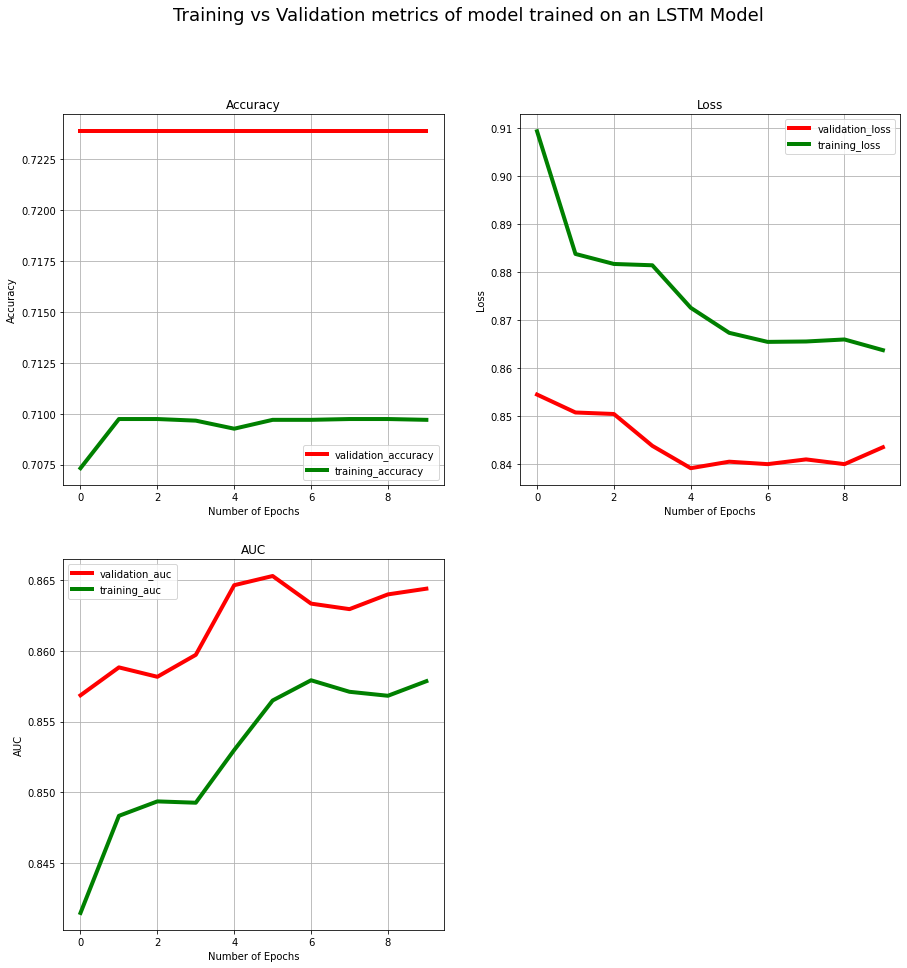

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_CV_History','rb') as f:
  LSTM_Lem_CV_History = pickle.load(f)

plot_LSTM_metrics(LSTM_Lem_CV_History)

####Combination 20 - LSTM + Stemming + Count Vectorizer####

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'COUNT' 
target_encoding = 'OH'
max_words = 1000
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_LSTM(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25264, 1000)
Shape of x_test (6316, 1000)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25264, 4)
size of y_test:  (6316, 4)


In [ ]:
LSTM_model_Stem_CV = build_model_CV(max_words)
epochs = 10
batch_size = 128

# LSTM_model_Stem_CV_History = LSTM_model_Stem_CV.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Stem_CV', 'wb') as files:
#     pickle.dump(LSTM_model_Stem_CV, files)
# with open('LSTM_Stem_CV_History','wb') as files:
#     pickle.dump(LSTM_model_Stem_CV_History,files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_CV' , 'rb') as f:
    LSTM_Stem_CV = pickle.load(f)

In [ ]:
y_test,preds=Classification_Report(x_test_embeds,y_train,y_test,LSTM_Stem_CV)
print(classification_report(y_test,preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Stem_CV', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 100s 505ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       603
           1       0.00      0.00      0.00       245
           2       0.71      1.00      0.83      4462
           3       0.00      0.00      0.00      1006

    accuracy                           0.71      6316
   macro avg       0.18      0.25      0.21      6316
weighted avg       0.50      0.71      0.58      6316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

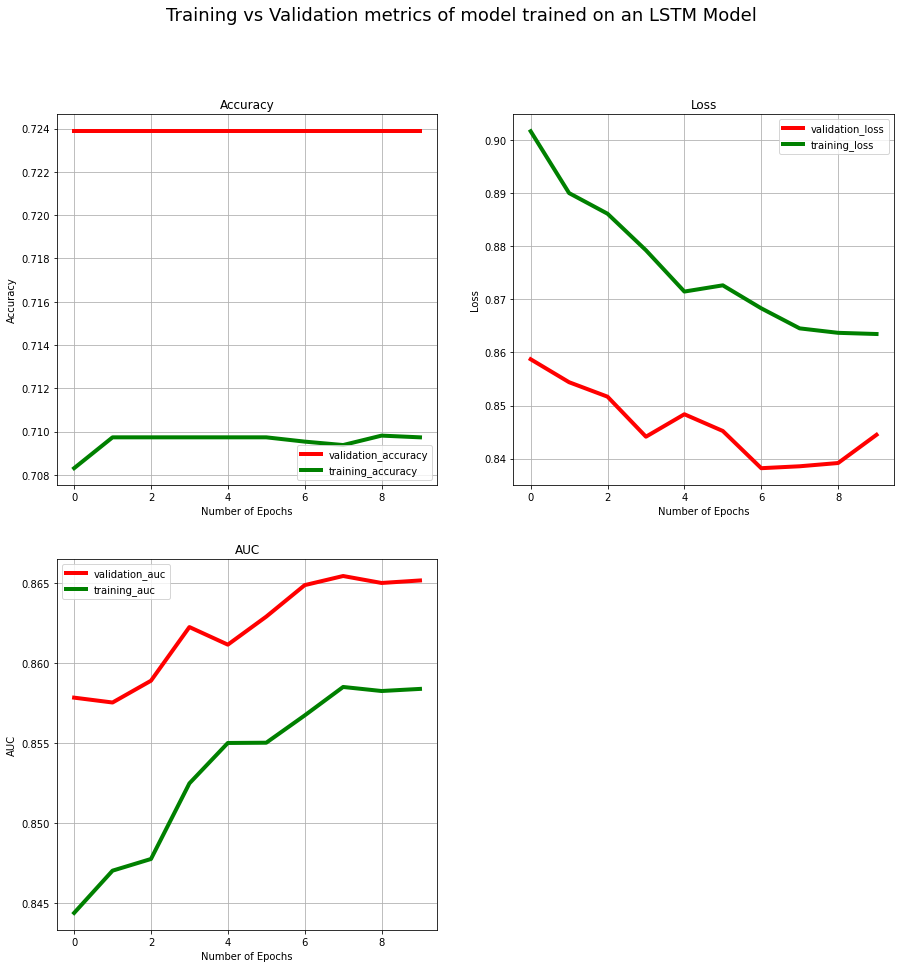

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_CV_History','rb') as f:
  LSTM_Stem_CV_History = pickle.load(f)

plot_LSTM_metrics(LSTM_Stem_CV_History)

In [ ]:
#Function to build model for TFIDF - trying out a different architecture from CV LSTM model
def build_model_TFIDF(max_words):
  model = tf.keras.Sequential()
  model.add(Bidirectional(LSTM(200, recurrent_dropout=0.1), input_shape = (max_words, 1)))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Precision','AUC','Recall','accuracy'])
  
  return model

####Combination 21 - LSTM + Stemming + TFIDF ####

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'TFIDF' 
target_encoding = 'OH'
max_words = 1000
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_LSTM(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25264, 1000)
Shape of x_test (6316, 1000)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25264, 4)
size of y_test:  (6316, 4)


In [ ]:
LSTM_model_Stem_TFIDF = build_model_TFIDF(max_words)
epochs = 5
batch_size = 128
# LSTM_model_Stem_TFIDF_History = LSTM_model_Stem_TFIDF.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Stem_TFIDF', 'wb') as files:
#     pickle.dump(LSTM_model_Stem_TFIDF, files)
# with open('LSTM_Stem_TFIDF_History', 'wb') as files:
#     pickle.dump(LSTM_model_Stem_TFIDF_History, files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_TFIDF' , 'rb') as f:
    LSTM_Stem_TFIDF = pickle.load(f)

In [ ]:
y_test,preds=Classification_Report(x_test_embeds,y_train,y_test,LSTM_Stem_TFIDF)
print(classification_report(y_test,preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Stem_TFIDF', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 101s 508ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       603
           1       0.00      0.00      0.00       245
           2       0.71      1.00      0.83      4462
           3       0.00      0.00      0.00      1006

    accuracy                           0.71      6316
   macro avg       0.18      0.25      0.21      6316
weighted avg       0.50      0.71      0.58      6316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

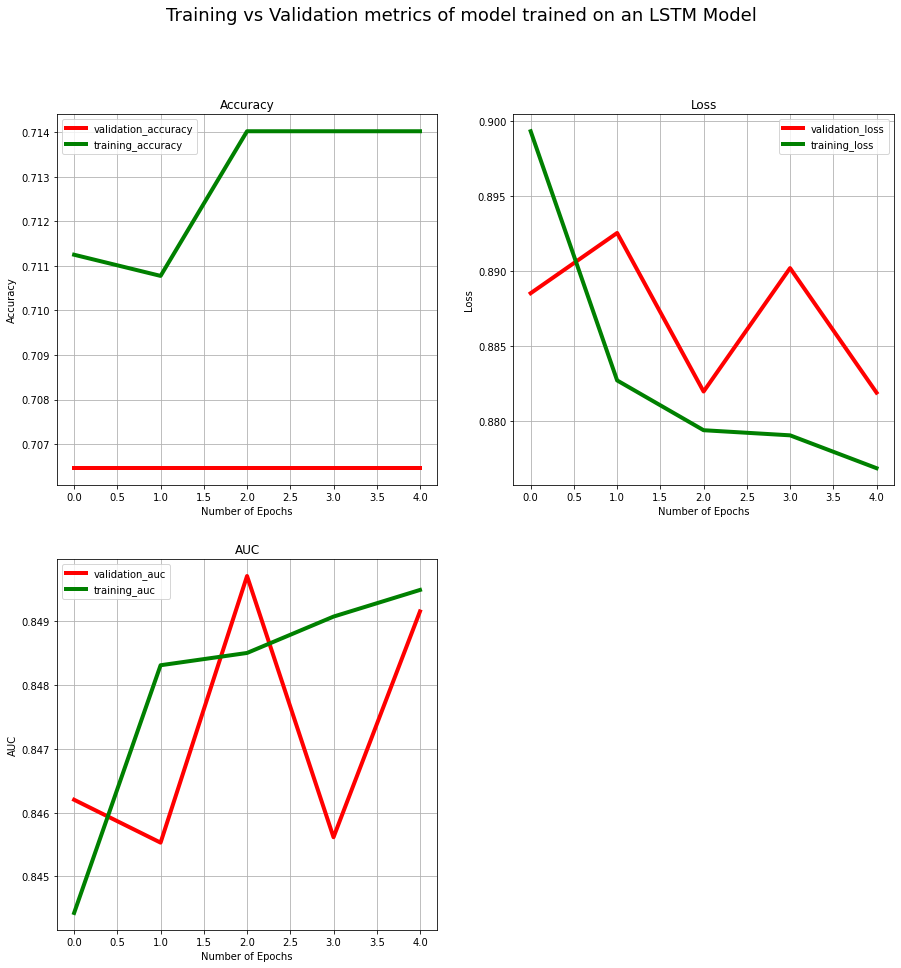

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_TFIDF_History','rb') as f:
  LSTM_Stem_TFIDF_History = pickle.load(f)

plot_LSTM_metrics(LSTM_Stem_TFIDF_History)

####Combination 22 - LSTM + Lemmatization + TFIDF ####

In [ ]:
preprocessing_method = 'Lemmatize'
embedding_method = 'TFIDF' 
target_encoding = 'OH'
max_words = 1000
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_LSTM(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25263, 1000)
Shape of x_test (6316, 1000)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25263, 4)
size of y_test:  (6316, 4)


In [ ]:
LSTM_model_Lem_TFIDF = build_model_TFIDF(max_words)
epochs = 5
batch_size = 128
# LSTM_model_Lem_TFIDF_History = LSTM_model_Lem_TFIDF.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Lem_TFIDF', 'wb') as files:
#     pickle.dump(LSTM_model_Lem_TFIDF, files)
# with open('LSTM_Lem_TFIDF_History', 'wb') as files:
#     pickle.dump(LSTM_model_Lem_TFIDF_History, files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_TFIDF' , 'rb') as f:
    LSTM_Lem_TFIDF = pickle.load(f)

In [ ]:
y_test,preds=Classification_Report(x_test_embeds,y_train,y_test,LSTM_Lem_TFIDF)
print(classification_report(y_test,preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Lem_TFIDF', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 101s 509ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       598
           1       0.00      0.00      0.00       253
           2       0.70      1.00      0.83      4445
           3       0.00      0.00      0.00      1020

    accuracy                           0.70      6316
   macro avg       0.18      0.25      0.21      6316
weighted avg       0.50      0.70      0.58      6316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

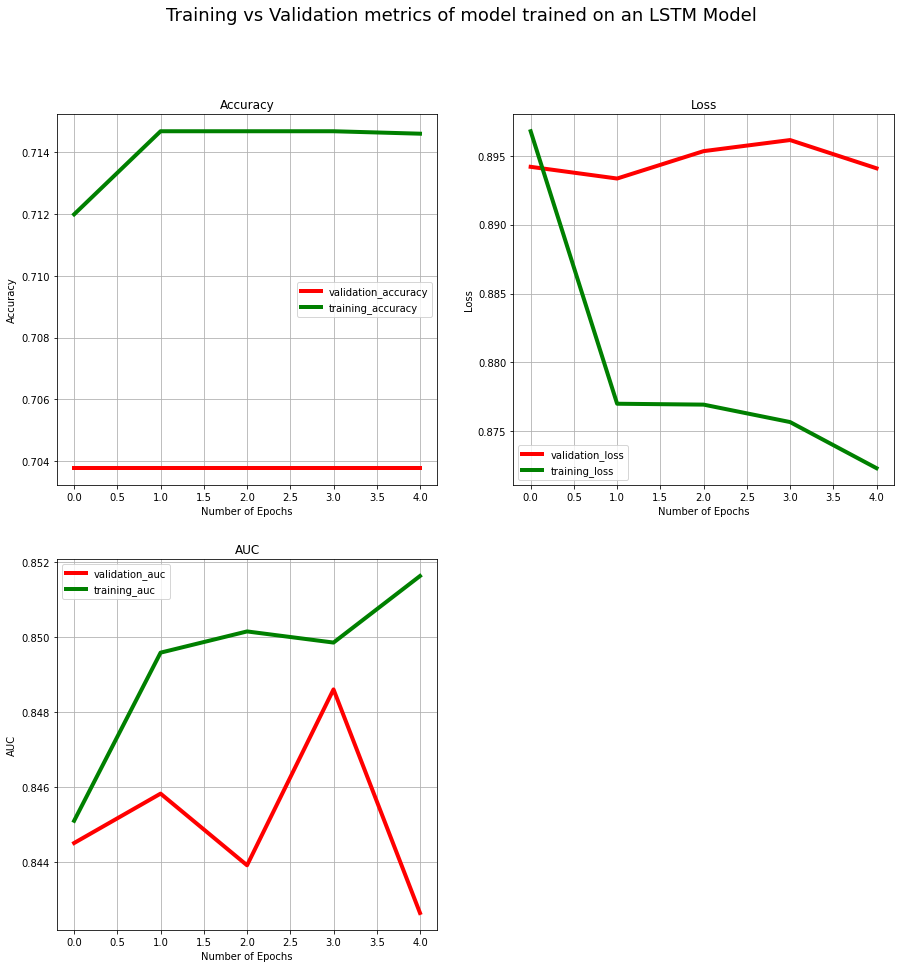

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_TFIDF_History','rb') as f:
  LSTM_Lem_TFIDF_History = pickle.load(f)

plot_LSTM_metrics(LSTM_Lem_TFIDF_History)

In [ ]:
#Function to prepare data for GLOVE and W2V - differs from previous functions because GLOVE and Word2Vec embedding returns an Embedding matrix which is feeded into the LSTM
def prepare_data_GLOVE_W2V(df, preprocessing_method, embedding_method,max_words, target_encoding):
    data = df.copy(deep=True)
    print("\n### CLEANING DATASET ###")
    print('Shape of dataset before cleaning', data.shape)
  
    data['tweet'] = data['tweet'].apply(clean_message,preprocessor = preprocessing_method)
    data = data[data['tweet'].apply(lambda x: str(x)!= "")]
    data.drop_duplicates(['tweet'],inplace = True,keep = 'first')

    print('Shape of dataset after cleaning', data.shape)

    print("\n### TRAIN - TEST SPLIT ###")

    x = data.iloc[:,1]
    y = data.iloc[:,2]
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=100)
    print('Shape of x_train',x_train.shape)
    print('Shape of x_test',x_test.shape)
    print('Shape of y_train',y_train.shape)
    print('Shape of x_test',y_test.shape)

    print("\n### EMBEDDING TEXTS ###")

    x_train_embeds, x_test_embeds, y_train, y_test,embedding_matrix = embedding(x_train,x_test,y_train,y_test,embedding_method,max_words)

    print("\n ### Shape after embeddings ###")

    print('Shape of x_train',np.array(x_train_embeds).shape)
    print('Shape of x_test',np.array(x_test_embeds).shape)
    print('Shape of y_train',np.array(y_train.shape).shape)
    print('Shape of x_test',np.array(y_test.shape).shape)

    print("\n### ENCODING TARGET VARIABLE ###")
    y_train_enc,y_test_enc = target_encoder(y_train,y_test,target_encoding)

    print("\n ### Shape of target after encoding ###")
    print("size of y_train: ",y_train_enc.shape)
    print("size of y_test: ",y_test_enc.shape)

    return x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix

In [ ]:
#Function to build model for GLOVE - architecture differs from the previously built models - a new embedding layer is added
def build_model_for_GLOVE(embedding_matrix):
  
  model = tf.keras.Sequential()
  model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                      output_dim=200, 
                      input_length=200, 
                      weights = [embedding_matrix], trainable=False))

  model.add(Bidirectional(LSTM(200, recurrent_dropout=0.1)))
  model.add(Dropout(0.1,seed = 100))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1,seed = 100))


  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Precision','AUC','Recall','accuracy'])
  return model

####Combination 23 - LSTM + Stemming + GLOVE ####

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'GLOVE' 
target_encoding = 'OH'
max_words = 200
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_GLOVE_W2V(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25264, 200)
Shape of x_test (6316, 200)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25264, 4)
size of y_test:  (6316, 4)


In [ ]:
LSTM_model_Stem_GLOVE = build_model_for_GLOVE(embedding_matrix)
print(LSTM_model_Stem_GLOVE.summary())
epochs = 10
batch_size = 128

# LSTM_model_Stem_Glove_history = LSTM_model_Stem_GLOVE.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Stem_GLOVE', 'wb') as files:
#     pickle.dump(LSTM_model_Stem_GLOVE, files)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          5418800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 400)              641600    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 400)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                25664     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                      

In [ ]:
# with open('LSTM_Stem_GLOVE_History','wb') as files:
#   pickle.dump(LSTM_model_Stem_Glove_history,files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_GLOVE', 'rb') as f:
    LSTM_Stem_GLOVE = pickle.load(f)

In [ ]:
preds = LSTM_Stem_GLOVE.predict(x_test_embeds)
preds = np.argmax(preds,axis = 1)
lEncoder = preprocessing.LabelEncoder()
y_test = lEncoder.fit_transform(y_test)
print(classification_report(y_test, preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Stem_GLOVE', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 21s 105ms/step
              precision    recall  f1-score   support

           0       0.79      0.67      0.73       603
           1       0.40      0.20      0.26       245
           2       0.81      0.89      0.85      4462
           3       0.46      0.35      0.40      1006

    accuracy                           0.76      6316
   macro avg       0.62      0.53      0.56      6316
weighted avg       0.73      0.76      0.74      6316



In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_GLOVE_History','rb') as f:
  LSTM_Stem_GLOVE_History = pickle.load(f)

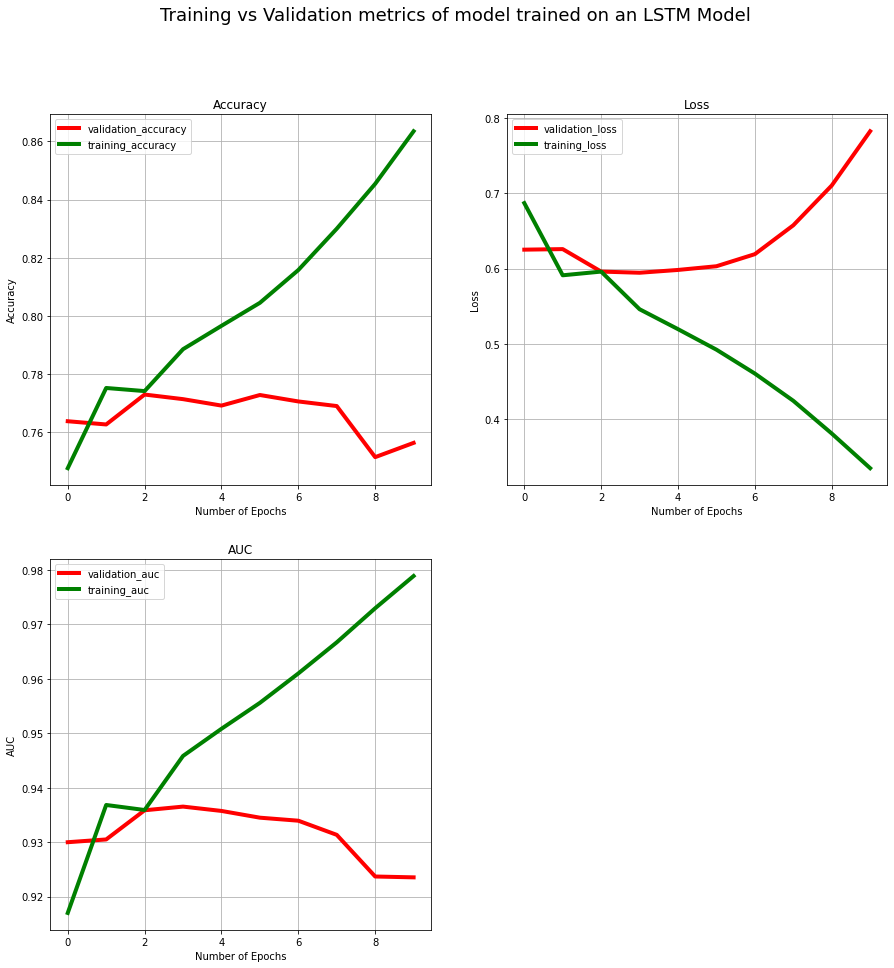

In [ ]:
plot_LSTM_metrics(LSTM_Stem_GLOVE_History)

####Combination 24 - LSTM + Lemmatization + GLOVE ####

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'GLOVE' 
target_encoding = 'OH'
max_words = 200
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_GLOVE_W2V(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25263, 200)
Shape of x_test (6316, 200)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25263, 4)
size of y_test:  (6316, 4)


In [ ]:
LSTM_model_Lem_GLOVE = build_model_for_GLOVE(embedding_matrix)
print(LSTM_model_Lem_GLOVE.summary())
epochs = 10
batch_size = 128

# LSTM_model_Lem_Glove_history = LSTM_model_Lem_GLOVE.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Lem_GLOVE', 'wb') as files:
#     pickle.dump(LSTM_model_Lem_GLOVE, files)
# with open('LSTM_Lem_GLOVE_History','wb') as files:
#   pickle.dump(LSTM_model_Lem_Glove_history,files)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          6863200   
                                                                 
 bidirectional_5 (Bidirectio  (None, 400)              641600    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 400)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                25664     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                      

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_GLOVE', 'rb') as f:
    LSTM_Lem_GLOVE = pickle.load(f)

In [ ]:
preds = LSTM_Lem_GLOVE.predict(x_test_embeds)
preds = np.argmax(preds,axis = 1)
lEncoder = preprocessing.LabelEncoder()
y_test = lEncoder.fit_transform(y_test)
print(classification_report(y_test, preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Lem_GLOVE', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 21s 106ms/step
              precision    recall  f1-score   support

           0       0.10      0.08      0.09       598
           1       0.05      0.03      0.04       253
           2       0.71      0.82      0.76      4445
           3       0.21      0.12      0.15      1020

    accuracy                           0.61      6316
   macro avg       0.27      0.26      0.26      6316
weighted avg       0.54      0.61      0.57      6316



In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_GLOVE_History', 'rb') as f:
    LSTM_Lem_GLOVE_History = pickle.load(f)

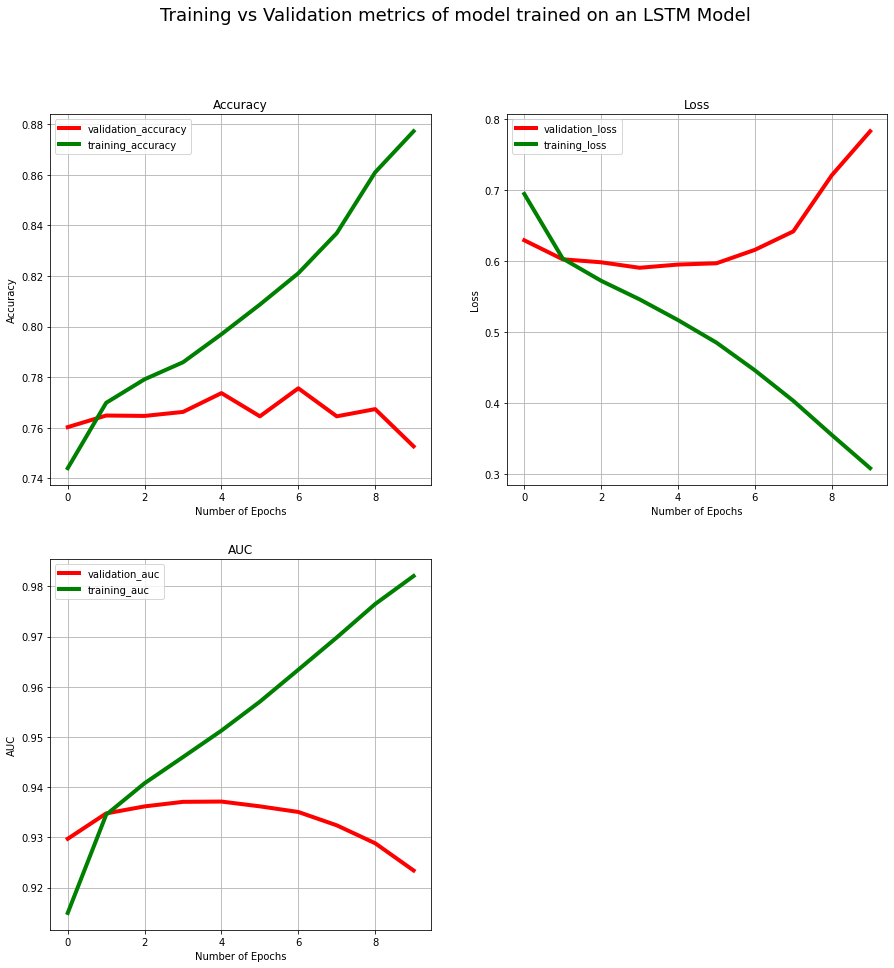

In [ ]:
plot_LSTM_metrics(LSTM_Lem_GLOVE_History)

In [ ]:
#Function to build a model using W2V Embedding matrix
def build_model_for_W2V(embedding_matrix):
  
  model = tf.keras.Sequential()
  
  model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=200, input_length=200, weights = [embedding_matrix], trainable=False))


  model.add(Bidirectional(LSTM(200,recurrent_dropout=0.1)))

  model.add(Dropout(0.1,seed = 100))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1,seed = 100))
  


  model.add(Dense(4, activation='softmax'))


  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['Precision','AUC','Recall','accuracy'])
  return model

####Combination 25 - LSTM + Stemming + W2V ####

In [ ]:
preprocessing_method = 'Stem' 
embedding_method = 'W2V' 
target_encoding = 'OH'
max_words = 1000
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_GLOVE_W2V(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31580, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25264,)
Shape of x_test (6316,)
Shape of y_train (25264,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25264, 200)
Shape of x_test (6316, 200)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25264, 4)
size of y_test:  (6316, 4)


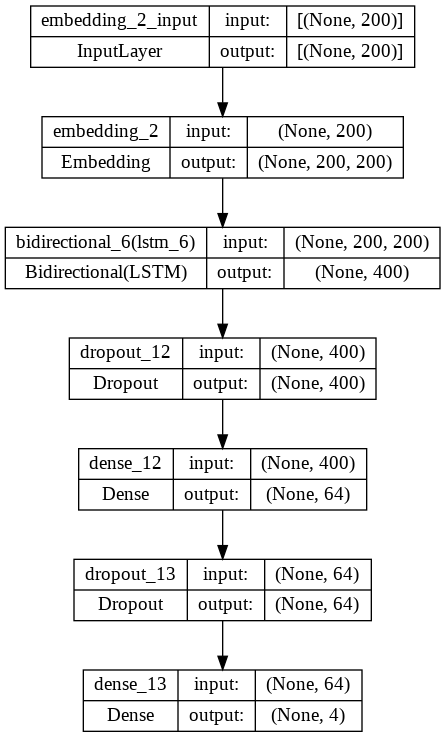

In [ ]:
LSTM_model_Stem_W2V = build_model_for_W2V(embedding_matrix)
plot_model(LSTM_model_Stem_W2V, to_file='model1.png', show_shapes=True)

In [ ]:
epochs = 10
batch_size = 128

# LSTM_model_Stem_W2V_History = LSTM_model_Stem_W2V.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Stem_W2V', 'wb') as files:
#     pickle.dump(LSTM_model_Stem_W2V, files)

In [ ]:
# with open('LSTM_Stem_W2V_History','wb') as files:
#   pickle.dump(LSTM_model_Stem_W2V_History,files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_W2V', 'rb') as f:
    LSTM_Stem_W2V = pickle.load(f)

In [ ]:
preds = LSTM_Stem_W2V.predict(x_test_embeds)
preds = np.argmax(preds,axis = 1)
lEncoder = preprocessing.LabelEncoder()
y_test = lEncoder.fit_transform(y_test)
print(classification_report(y_test, preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Stem_W2V', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 21s 105ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       603
           1       0.00      0.00      0.00       245
           2       0.71      1.00      0.83      4462
           3       0.00      0.00      0.00      1006

    accuracy                           0.71      6316
   macro avg       0.18      0.25      0.21      6316
weighted avg       0.50      0.71      0.58      6316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

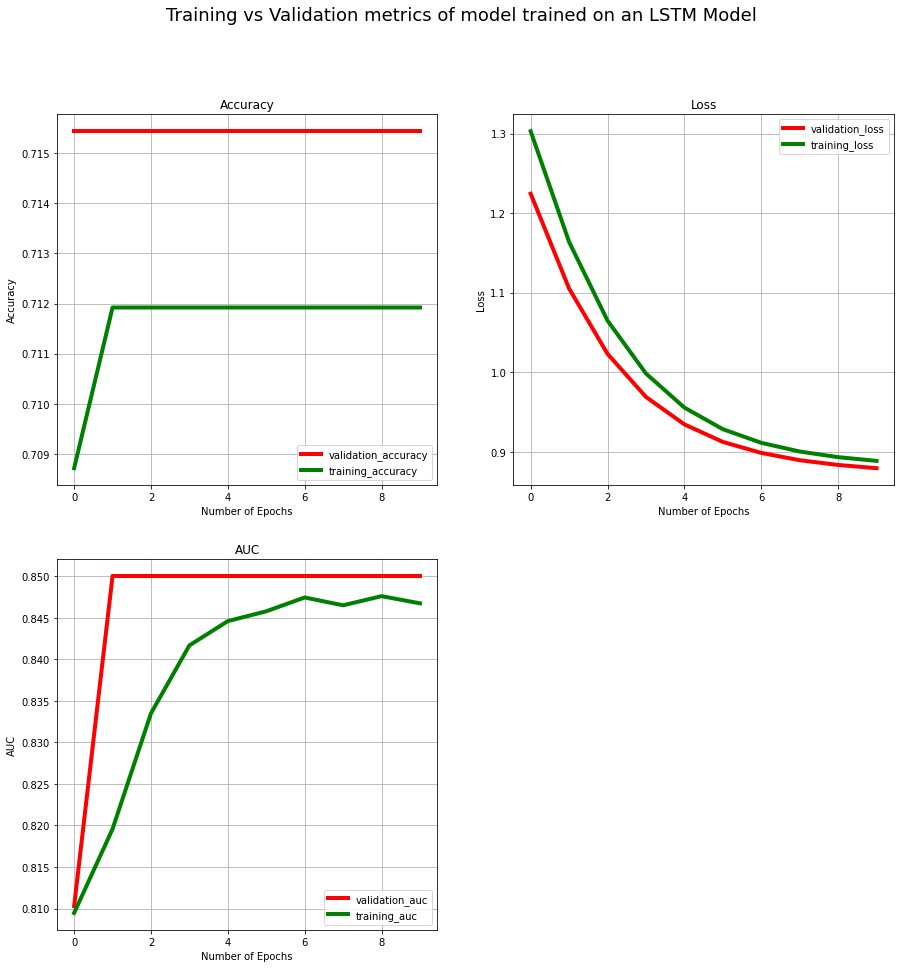

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Stem_W2V_History','rb') as f:
  LSTM_Stem_W2V_History = pickle.load(f)
  
plot_LSTM_metrics(LSTM_Stem_W2V_History)

####Combination 26 - LSTM + Lemmatization + W2V ####

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'W2V' 
target_encoding = 'OH'
max_words = 1000
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_GLOVE_W2V(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25263, 200)
Shape of x_test (6316, 200)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25263, 4)
size of y_test:  (6316, 4)


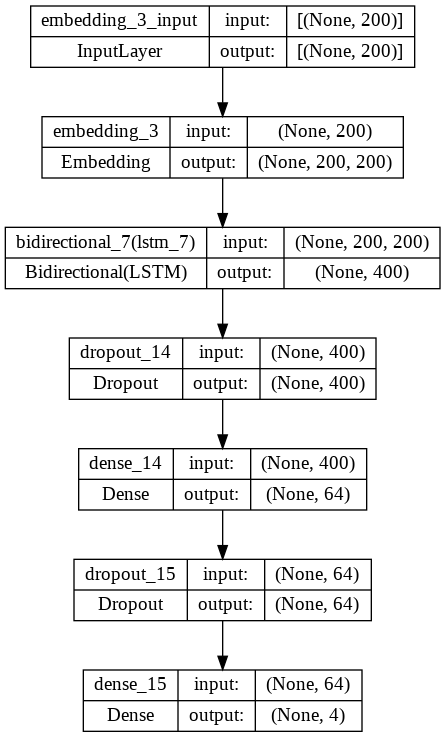

In [ ]:
LSTM_model_Lem_W2V = build_model_for_W2V(embedding_matrix)
plot_model(LSTM_model_Lem_W2V, to_file='model1.png', show_shapes=True)

In [ ]:
epochs = 10
batch_size = 128

# LSTM_model_Lem_W2V_History = LSTM_model_Lem_W2V.fit(x_train_embeds, y_train_enc, epochs=epochs, batch_size = batch_size,validation_data=(x_test_embeds, y_test_enc))
# with open('LSTM_Lem_W2V', 'wb') as files:
#     pickle.dump(LSTM_model_Lem_W2V, files)

In [ ]:
# with open('LSTM_Lem_W2V_History','wb') as files:
#   pickle.dump(LSTM_model_Lem_W2V_History,files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_W2V', 'rb') as f:
    LSTM_Lem_W2V = pickle.load(f)

In [ ]:
preds = LSTM_Lem_W2V.predict(x_test_embeds)
preds = np.argmax(preds,axis = 1)
lEncoder = preprocessing.LabelEncoder()
y_test = lEncoder.fit_transform(y_test)
print(classification_report(y_test, preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Lem_W2V', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 22s 106ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       598
           1       0.00      0.00      0.00       253
           2       0.70      1.00      0.83      4445
           3       0.00      0.00      0.00      1020

    accuracy                           0.70      6316
   macro avg       0.18      0.25      0.21      6316
weighted avg       0.50      0.70      0.58      6316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

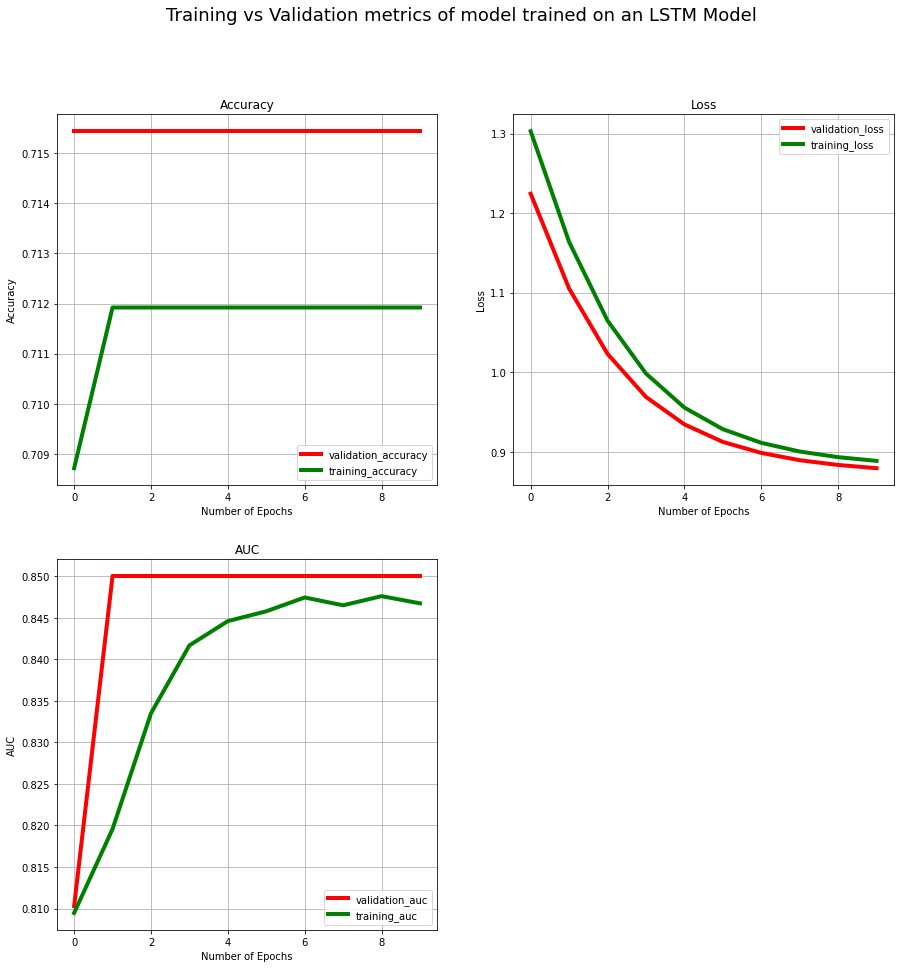

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Lem_W2V_History', 'rb') as f:
    LSTM_Lem_W2V_History = pickle.load(f)
plot_LSTM_metrics(LSTM_Lem_W2V_History)

In [ ]:
Results_LSTM_DF

,ModelName,Precision,Recall,F-1Score
0,LSTM_Lem_CV,0.495290,0.703768,0.581405
0,LSTM_Stem_CV,0.499085,0.706460,0.584937
0,LSTM_Stem_TFIDF,0.499085,0.706460,0.584937
0,LSTM_Lem_TFIDF,0.495290,0.703768,0.581405
0,LSTM_Stem_GLOVE,0.734957,0.756333,0.741221
0,LSTM_Lem_GLOVE,0.542313,0.605763,0.568286
0,LSTM_Stem_W2V,0.499085,0.706460,0.584937
0,LSTM_Lem_W2V,0.495290,0.703768,0.581405


We can see that compared to the Naive Bayes and SVM, the LSTM models are not performing much better. The major cause could be the limited number of epochs which was only 10.

We will attempt to train a hyperparameter tuned version of LSTM, and try fitting it with a fast running and yet relatively high recall model of Lemmatization as the preprocessing technique and W2V as the embedding method

In [ ]:

# Function to define the hyperparameter grid for the LSTM network - this is passed to the Keras Tuner library
def build_model(hp):
    embedding_dim=200
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=x_train_embeds.shape[1]))
    model.add(Dropout(hp.Float('Dropout_rate_1',min_value=0,max_value=0.5,step=0.1)))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=128,step=32)))
    model.add(Flatten())
    model.add(Dropout(hp.Float('Dropout_rate_2',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(hp.Int('hidden_size', 30, 100, step=10, default=50),activation= hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Float('Dropout_rate_3',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),loss='categorical_crossentropy',metrics = ['Precision'])
    return model


####Combination 27 - Optimized LSTM + Lemmatization + W2V ####

In [ ]:
preprocessing_method = 'Lemmatize' 
embedding_method = 'W2V' 
target_encoding = 'OH'
max_words = 1000
x_train_embeds,y_train_enc,x_test_embeds,y_test_enc,y_train,y_test,embedding_matrix = prepare_data_GLOVE_W2V(df, preprocessing_method, embedding_method,max_words, target_encoding)


### CLEANING DATASET ###
Shape of dataset before cleaning (34260, 3)
Shape of dataset after cleaning (31579, 3)

### TRAIN - TEST SPLIT ###
Shape of x_train (25263,)
Shape of x_test (6316,)
Shape of y_train (25263,)
Shape of x_test (6316,)

### EMBEDDING TEXTS ###

 ### Shape after embeddings ###
Shape of x_train (25263, 200)
Shape of x_test (6316, 200)
Shape of y_train (1,)
Shape of x_test (1,)

### ENCODING TARGET VARIABLE ###
{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'sparse': True}

 ### Shape of target after encoding ###
size of y_train:  (25263, 4)
size of y_test:  (6316, 4)


Below we are using Keras tuner library for Hyper parameter tuning. We have defined the parameter grid for the LSTM netword in the above function

In [ ]:
# tuner= RandomSearch(
#         build_model,
#         keras_tuner.Objective('val_precision','max'),
#         max_trials=30,
#         overwrite=True
#         )

In [ ]:
# tuner.search(
#         x=x_train_embeds,
#         y=y_train_enc,
#         epochs=10,
#         batch_size=128,
#         validation_data=(x_test_embeds,y_test_enc),
# )

In [ ]:
# LSTM_model_Optimized = tuner.get_best_models(num_models=1)[0]
# LSTM_model_Optimized.evaluate(x_test_embeds,y_test_enc)
# with open('LSTM_Optimized','wb') as files:
#   pickle.dump(LSTM_model_Optimized,files)

In [ ]:
with open('/content/drive/MyDrive/ADSProject/Models/LSTM_Optimized','rb') as f:
  LSTM_Optimized = pickle.load(f)

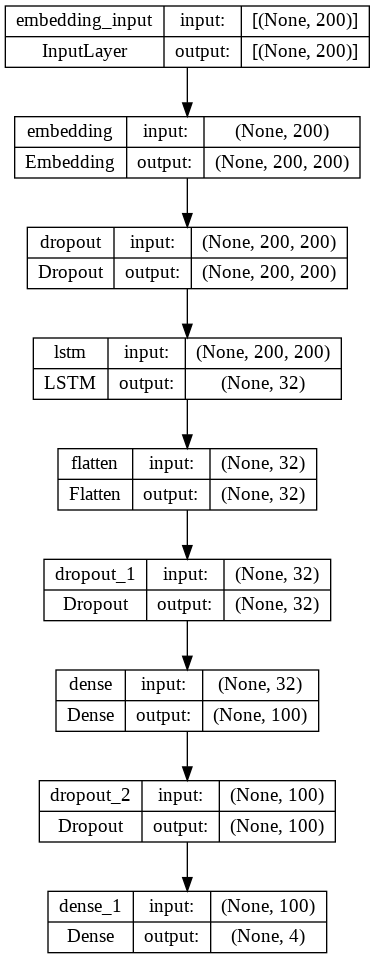

In [ ]:
plot_model(LSTM_Optimized, to_file='model1.png', show_shapes=True)

In [ ]:
preds = LSTM_Optimized.predict(x_test_embeds)
preds = np.argmax(preds,axis = 1)
lEncoder = preprocessing.LabelEncoder()
y_test = lEncoder.fit_transform(y_test)
print(classification_report(y_test, preds))
Metrics = pd.DataFrame({'ModelName':'LSTM_Optimized', 'Precision':precision_score(y_test,preds,average='weighted'),'Recall':recall_score(y_test,preds,average='weighted'),'F-1Score':f1_score(y_test,preds,average='weighted')},index = [0])
Results_LSTM_DF = pd.concat([Results_LSTM_DF,Metrics])

198/198 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.74      0.71      0.73       598
           1       0.00      0.00      0.00       253
           2       0.79      0.96      0.87      4445
           3       0.60      0.18      0.27      1020

    accuracy                           0.77      6316
   macro avg       0.53      0.46      0.47      6316
weighted avg       0.72      0.77      0.72      6316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [ ]:
Results_LSTM_DF.head(10)

,ModelName,Precision,Recall,F-1Score
0,LSTM_Lem_CV,0.495290,0.703768,0.581405
0,LSTM_Stem_CV,0.499085,0.706460,0.584937
0,LSTM_Stem_TFIDF,0.499085,0.706460,0.584937
0,LSTM_Lem_TFIDF,0.495290,0.703768,0.581405
0,LSTM_Stem_GLOVE,0.734957,0.756333,0.741221
0,LSTM_Lem_GLOVE,0.542313,0.605763,0.568286
0,LSTM_Stem_W2V,0.499085,0.706460,0.584937
0,LSTM_Lem_W2V,0.495290,0.703768,0.581405
0,LSTM_Optimized,0.719921,0.773274,0.722092


We can see that the optimized LSTM has considerably better performance over the previous LSTM network that we defined and trained with the same preprocessing method andembedding technique

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Precision', x=Results_LSTM_DF['ModelName'], y=Results_LSTM_DF['Precision']),
    go.Bar(name='Recall', x=Results_LSTM_DF['ModelName'], y=Results_LSTM_DF['Recall']),
    go.Bar(name='F1-Score', x=Results_LSTM_DF['ModelName'], y=Results_LSTM_DF['F-1Score'])
])
fig.update_layout(title = 'LSTM Metrics Results Plot')
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(range=[0.4,0.8], dtick=0.01)
fig.show()

We can see in the above plot that the hyperparameter tuned version of LSTM stands out in its performance.

###Final Results Visualization with Model Comparison###

We will now visualize the model performance of each of the three models and each of 8 the ablation settings and hyperparameter tuned version for these three models - totalling 27 different models. We will compare each of the three key metrics - Precision, Recall and F-1 Score

In [3]:
final_results= pd.read_csv('/content/drive/MyDrive/ADSProject/Models/Results_Metrics.csv')

In [4]:
final_results.head(30)

,ModelName,Precision,Recall,F-1Score
0,NB_Stem_CV,0.734803,0.740975,0.735691
1,NB_Lem_CV,0.733198,0.746517,0.737260
2,NB_Stem_TFIDF,0.743577,0.759183,0.711483
3,NB_Lem_TFIDF,0.746430,0.758866,0.712809
4,NB_Lem_W2V,0.692319,0.635987,0.656589
5,NB_Stem_W2V,0.698390,0.643585,0.664192
6,NB_Stem_GLOVE,0.685909,0.601809,0.630187
7,NB_Lem_GLOVE,0.679972,0.568413,0.603123
8,NB_Stem_TFIDF_Optimized,0.734831,0.758391,0.716159
9,SVM_Lem_CV,0.746602,0.771374,0.714424


In [7]:
fig = go.Figure(go.Bar(x=final_results['Precision'], y=final_results['ModelName'], orientation='h'))
fig.update_layout(yaxis={'categoryorder':'total ascending'},title ='Visualizing Precision of all models')
fig.show()

We can see that Precision is high for the Optimized SVM with lemmatization and Count Vectorization. High precision indicates that any prediction that the model makes for a particular class is highly likely to be a true positive

In [8]:
fig = go.Figure(go.Bar(x=final_results['Recall'], y=final_results['ModelName'], orientation='h')) 
fig.update_layout(xaxis={'categoryorder':'total ascending'},yaxis={'categoryorder':'total ascending'},title ='Visualizing Recall of all models')
fig.show()

High Recall means that it is highly likely that the model will predict positives correctly, even if some are false positives. We can see that the optimized LSTM has a high recall, but the Optimized SVM has high recall and high precision.

In [9]:
fig = go.Figure(go.Bar(x=final_results['F-1Score'], y=final_results['ModelName'], orientation='h')) 
fig.update_layout(yaxis={'categoryorder':'total ascending'},title ='Visualizing F-1 Scores of all models')
fig.show()

F1 score is the harmonic mean of Precision and Recall - we can see that the top contender that is the Optimized SVM has a lower F1 score as compared to other models, but it is still in the top 5. 

In [10]:
fig = go.Figure(data=[
    go.Bar(name='Precision', x=final_results['ModelName'], y=final_results['Precision']),
    go.Bar(name='Recall', x=final_results['ModelName'], y=final_results['Recall']),
    go.Bar(name='F1-Score', x=final_results['ModelName'], y=final_results['F-1Score'])
])
fig.update_layout(title = 'Comparing Metrics of all models - Results Plot', xaxis={'categoryorder':'total ascending'})
# Change the bar mode
fig.update_layout(barmode='group')
#fig.update_yaxes(range=[0.4,0.8], dtick=0.01)
fig.show()

###Conclusion###

In this project, we have successfully done the following:
* Explored the features and metafeatures of a twitter tweets dataset that is classified into one of four classes - Normal, Spam, Abusive and Hateful
* We found patterns in the metafeatures which lead us to believe that abusive and hateful tweets generally contain lesser words and rarely uses up the full 140 character limit of tweets.
* We then used two different preprocessing methods, Stemming and Lemmatization in combination with four different embedding methods - Count Vectorizer, TF-IDF, GLOVE and Word2Vec
* We tried all 8 combinations of the above with 3 different model types - Naive Bayes, SVM and LSTM.
* We compared the performance of the models using 3 major metrics used for any classification task - Precision, Recall and F1 score.
* We then picked the best performing ablation setting for each of the models, and used GridSearchCV for hyperparameter tuning Naive Bayes model, RandomSearchCV for hyperparameter tuning the SVM model and finally, Keras tuner for hyperparameter tuning the LSTM.
* Comparing all the metrics of all the optimized and default models against each ablation setting (27 in total), we saw that the Optimized SVM model with Lemmatization and Count Vectorization stood out as the best performing model.
* Since the task at hand is to classify tweets as abusive, hateful, normal or spam, we prefer a model that has high recall, and can tolerate low precision and F1 score. The reason being, we would rather have our model correctly classify an abusive tweet as abusive, and incorrectly classify a normal tweet as abusive THAN miss classifying an abusive tweet altogether.

### References ###
1. https://en.wikipedia.org/wiki/Precision_and_recall
2. https://monkeylearn.com/text-classification-support-vector-machines-svm/
3. https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a
4. https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset/code?select=labeled_data.csv
5. https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset/code?select=labeled_data.csv
6. https://www.kaggle.com/code/mkowoods/deep-learning-lstm-for-tweet-classification